<link rel="stylesheet" href="https://fonts.googleapis.com/css?family=Sofia">
<style>
  @import url('https://fonts.googleapis.com/css2?family=Concert+One&display=swap');
  .topic {
    text-align: center;
    font-weight: 900;
    font-size: 50px;
    text-shadow: 3px 3px 3px #ababab;
    font-family: 'Concert One', sans-serif;
  }
  @import url('https://fonts.googleapis.com/css2?family=Lobster&display=swap');
  .info {
    text-align: center;
    font-weight: 800;
    font-size: 40px;
    font-family: 'Lobster', sans-serif;
  }
</style>

<h1 class=topic>Google Analytics Customer Revenue Prediction</h1>
<h2 class=info>Vũ Minh Phát - 21127739</h2>

---

## **<u>Các thư viện cần sử dụng</u>**

In [1]:
# Import common libraries
import numpy as np
import pandas as pd
from pandas import json_normalize
import json
from zipfile import ZipFile # to unzip the data
import tqdm # displays a progress bar
import datetime as dt
import re
pd.set_option('display.max_columns', None)

# Import libraries for visualisation
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
%matplotlib inline

from wordcloud import WordCloud

# Some built-in utilities
from typing import List

---

## **<u>Đọc dữ liệu thô từ file</u>**

### 1. Xây dựng hàm đọc dữ liệu

In [2]:
# ********** A USEFUL WAY TO READ VERY LARGE DATASETS COMPRESSED IN ZIP FILES **********
#
#   1.  After downloading the data from Kaggle, we will have a zip file
#           which contain our dataset in csv format.
#
#   2.  Because of (very) large size of the dataset, we will not extract the zip file
#           which help us to save our disk space.
#
#   3.  To read file csv in size the zip file, we will use ZipFile library.
#           so we need to define the path to the zip file.
#
#   4.  After that, we can use pandas to read the csv file like normal.
#
# Read more at: https://favtutor.com/blogs/zipfile-python#:~:text=How%20to%20read%20a%20zip,that%20we%20want%20to%20read.
# **************************************************************************************
ZIP_FILE_PATH = '../data/raw/ga-customer-revenue-prediction.zip'

In [3]:
def read_data_inside_zip_file(filename: str, zip_file_path: str = ZIP_FILE_PATH) -> pd.DataFrame:
    """Read the csv file inside the zip file
    
    Notes:
        zip_file_path is the path to the zip file containing the csv file

    Returns:
        pd.DataFrame: dataframe of 'filename' inside the zip file
    """
    with ZipFile(zip_file_path) as zf:      # Open the zip file with mode 'r'
        with zf.open(filename) as file:     # Open 'filename' inside the zip file
            df = pd.read_csv(file)          # Read data from 'filename'
                                            #   => Q: Why NOT set low_memory=False to solve DtypeWarning?
                                            #      A: Read at: https://stackoverflow.com/questions/24251219/pandas-read-csv-low-memory-and-dtype-options

    return df

### 2. Đọc dữ liệu

In [4]:
# Read the data
raw_df = read_data_inside_zip_file('train.csv')

/tmp/ipykernel_934/1298650587.py:12: DtypeWarning:

Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.



> Khi sử dụng `read_csv()` từ `Pandas`, thông báo `DtypeWarning` xuất hiện 
> đồng nghĩa với việc file dữ liệu có (ít nhất) 1 cột bao gồm nhiều kiểu dữ liệu (dtype).

Cột gây ra thông báo là:

In [5]:
# Columns (3) give DtypeWarning -> corresponding index is 3
print(f"=> Column give DtypeWarning: {raw_df.columns[3]}")

=> Column give DtypeWarning: fullVisitorId


> Trong trường hợp này, cột `fullVisitorId` là nguyên nhân của thông báo trên. Ta sẽ quan sát toàn bộ dữ liệu đã đọc và tìm cách xử lý.

Ta xem một vài dòng có trong tập dữ liệu:

In [7]:
raw_df.head(5)

,channelGrouping,date,device,fullVisitorId,geoNetwork,sessionId,socialEngagementType,totals,trafficSource,visitId,visitNumber,visitStartTime
0,Organic Search,20160902,"{""browser"": ""Chrome"", ""browserVersion"": ""not a...",1131660440785968503,"{""continent"": ""Asia"", ""subContinent"": ""Western...",1131660440785968503_1472830385,Not Socially Engaged,"{""visits"": ""1"", ""hits"": ""1"", ""pageviews"": ""1"",...","{""campaign"": ""(not set)"", ""source"": ""google"", ...",1472830385,1,1472830385
1,Organic Search,20160902,"{""browser"": ""Firefox"", ""browserVersion"": ""not ...",377306020877927890,"{""continent"": ""Oceania"", ""subContinent"": ""Aust...",377306020877927890_1472880147,Not Socially Engaged,"{""visits"": ""1"", ""hits"": ""1"", ""pageviews"": ""1"",...","{""campaign"": ""(not set)"", ""source"": ""google"", ...",1472880147,1,1472880147
2,Organic Search,20160902,"{""browser"": ""Chrome"", ""browserVersion"": ""not a...",3895546263509774583,"{""continent"": ""Europe"", ""subContinent"": ""South...",3895546263509774583_1472865386,Not Socially Engaged,"{""visits"": ""1"", ""hits"": ""1"", ""pageviews"": ""1"",...","{""campaign"": ""(not set)"", ""source"": ""google"", ...",1472865386,1,1472865386
3,Organic Search,20160902,"{""browser"": ""UC Browser"", ""browserVersion"": ""n...",4763447161404445595,"{""continent"": ""Asia"", ""subContinent"": ""Southea...",4763447161404445595_1472881213,Not Socially Engaged,"{""visits"": ""1"", ""hits"": ""1"", ""pageviews"": ""1"",...","{""campaign"": ""(not set)"", ""source"": ""google"", ...",1472881213,1,1472881213
4,Organic Search,20160902,"{""browser"": ""Chrome"", ""browserVersion"": ""not a...",27294437909732085,"{""continent"": ""Europe"", ""subContinent"": ""North...",27294437909732085_1472822600,Not Socially Engaged,"{""visits"": ""1"", ""hits"": ""1"", ""pageviews"": ""1"",...","{""campaign"": ""(not set)"", ""source"": ""google"", ...",1472822600,2,1472822600


---

## 📌 Dữ liệu thô có bao nhiêu dòng và bao nhiêu cột?

Mô tả tổng quát dữ liệu

In [8]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 903653 entries, 0 to 903652
Data columns (total 12 columns):
 #   Column                Non-Null Count   Dtype 
---  ------                --------------   ----- 
 0   channelGrouping       903653 non-null  object
 1   date                  903653 non-null  int64 
 2   device                903653 non-null  object
 3   fullVisitorId         903653 non-null  object
 4   geoNetwork            903653 non-null  object
 5   sessionId             903653 non-null  object
 6   socialEngagementType  903653 non-null  object
 7   totals                903653 non-null  object
 8   trafficSource         903653 non-null  object
 9   visitId               903653 non-null  int64 
 10  visitNumber           903653 non-null  int64 
 11  visitStartTime        903653 non-null  int64 
dtypes: int64(4), object(8)
memory usage: 82.7+ MB


Ta tìm số lượng dòng và cột của tập dữ liệu để trả lời câu hỏi

In [9]:
# Calculate the number of rows and columns
nrows, ncols = raw_df.shape

# Answer the question
print(f">> Number of rows: {nrows}")
print(f">> Number of columns: {ncols}")

>> Number of rows: 903653
>> Number of columns: 12


> 💭 Dữ liệu thô có `903653 dòng` và `12 cột`.

## 📌 Mỗi dòng có ý nghĩa là gì? Dữ liệu có gặp phải vấn đề các dòng có ý nghĩa khác nhau hay không?

> 🖋️ <u>*Trả lời:*</u>
>   * Mỗi dòng sẽ lưu các thông tin trong một phiên truy cập tới GStore từ người dùng. Cụ thể hơn, mỗi dòng cho ta biết *12* thông tin ứng với *12* trường dữ liệu (còn ý nghĩa của mỗi trường dữ liệu thì ta sẽ đề cập sau).
>
>   * Nhìn sơ qua toàn bộ bảng dữ liệu trong file `train.csv` được cung cấp bởi [Kaggle](https://www.kaggle.com/competitions/ga-customer-revenue-prediction/data?select=train.csv) thì có vẻ không thấy có dòng nào bất thường. Các dòng đều có cấu trúc giống nhau, thể hiện thông qua <u>thứ tự</u> và <u>kiểu dữ liệu</u> mà nó lưu trữ. (Và điều này được thể hiện rất rõ khi quan sát hình bên dưới, ta thấy thứ tự lưu trữ của mỗi dòng đều giống nhau: đầu tiên là đoạn văn bản, kế tiếp là 8 chữ số, sau đó đến 1 dữ liệu hỗn hợp khá giống `dictionary`, v.v.)
>
> ![Demo `train.csv`](./figures/demo_train_csv.png "Demo `train.csv`")

## 📌 Dữ liệu có các dòng bị lặp không?

Ta tính số lượng các dòng bị trùng `index`. Trong số các dòng có `index` giống nhau, thì dòng đầu tiên không được tính là lặp lại.

In [10]:
# Calculate the number of duplicated rows
index = raw_df.index
detectDupSeries = index.duplicated(keep='first')
num_duplicated_rows = detectDupSeries.sum()

# Show the result
if num_duplicated_rows == 0: 
    print(f">> Your raw data have no duplicated line!")
else:
    ext = "lines" if num_duplicated_rows > 1 else "line"
    print(f">> Your raw data have {num_duplicated_rows} duplicated " + ext + ". Please de-deduplicate your raw data!")

>> Your raw data have no duplicated line!


> 💭 <u>*Nhận xét:*</u> Dữ liệu của chúng ta không có dòng nào bị lặp lại nên ta không cần xử lý gì thêm. Tiếp theo, ta sẽ chuyển sang tìm hiểu về các cột.

## 📌 Mỗi cột có ý nghĩa là gì?

<class style="font-size: 18px;">

> Ý nghĩa của từng cột:
> * **`channelGrouping`** - Cho biết kênh mà người dùng đã truy cập đến GStore (Google swag online store).
> 
> * **`date`** - Cho biết Ngày mà người dùng truy cập vào GStore.
> 
> * **`device`** - Chứa thông số kỹ thuật của thiết bị được sử dụng để truy cập vào GStore và thể hiện dưới dạng <u>giá trị tổng hợp</u>. (Ví dụ: tên và phiên bản của `browser`; hệ điều hành của thiết bị; v.v.)
> 
> * **`fullVisitorId`** - Cho biết mã định danh riêng cho mỗi người dùng của Google Merchandise Store.
> 
> * **`geoNetwork`** - Cho biết thông tin vị trí địa lý của người dùng được thể hiện dưới dạng <u>giá trị tổng hợp</u>. (Chẳng hạn như tên của: `city`, `continent`, `country`, v.v.)
> 
> * **`sessionId`** - Được tạo thành từ **`fullVisitorId`** và **`visitId`**.
> 
> * **`socialEngagementType`** - Chứa một trong hai giá trị: "Socially Engaged" hoặc "Not Socially Engaged".
> 
> * **`totals`** - Chứa các <u>giá trị tổng hợp</u> trong suốt phiên ghé thăm của mỗi người dùng. (Ví dụ như: số lượng trang đã xem; tổng thời gian của phiên được tính bằng giây; v.v.)
> 
> * **`trafficSource`** - Cho biết thông tin về Traffic Source mà phiên bắt đầu, được thể hiện dưới dạng <u>giá trị tổng hợp</u>. (Chẳng hạn như: `keyword` hay chuỗi đường dẫn đưa người dùng đến trang web, v.v.)
> 
> * **`visitId`** - Cho biết mã định danh của mỗi phiên (giá trị này có thể giống nhau ở các người dùng khác nhau). Đây là một phần của giá trị thường được lưu trữ dưới dạng cookie `_utmb`.
> 
> * **`visitNumber`** - Lưu trữ số lượng phiên truy cập của từng người dùng. Nếu đây là phiên đầu tiên thì giá trị này được đặt thành *1*. Giá trị này tăng dần sau mỗi lần người dùng truy cập đến trang web.
> 
> * **`visitStartTime`** - Timestamp (được biểu thị bằng thời gian POSIX) cho biết thời gian người dùng bắt đầu truy cập đến trang web.
>
<i>(Những thông tin mô tả bên trên đã được tham khảo từ 2 nguồn tài liệu là: [Kaggle - Dataset Description](https://www.kaggle.com/competitions/ga-customer-revenue-prediction/data) và [[UA] BigQuery Export schema](https://support.google.com/analytics/answer/3437719?hl=en-GBanswer=1686200))</i>

</class>

## 📌 Cách thức lưu trữ dữ liệu trong các cột như hiện tại có phù hợp để có thể xử lý tiếp hay không?

- Dữ liệu ban đầu có 12 cột. Sau khi tìm hiểu về ý nghĩa của chúng thì ta phát hiện có 4 thuộc tính là: `device`, `geoNetwork`, `totals` và `trafficSource` đang lưu trữ dữ liệu dưới dạng `JSON` (dữ liệu hỗn hợp) rất khó để phân tích.

- Vậy ta đề ra giải pháp là cần *"làm phẳng"* dữ liệu, tức là: biến đổi dữ liệu thô từ trong file `train.csv` thành một bảng dữ liệu, sao cho mỗi cột chỉ thể hiện một thông tin duy nhất (và không thể chia nhỏ hơn nữa).

## 🚧 Tiền xử lý: Đọc dữ liệu và làm phẳng

Ta có thể sử dụng đoạn code của [DATAISTA0 (JULIÁN PELLER)](https://www.kaggle.com/code/julian3833/1-quick-start-read-csv-and-flatten-json-fields/notebook) để thực hiện việc này.

In [3]:
# From: https://www.kaggle.com/julian3833/1-quick-start-read-csv-and-flatten-json-fields
def read_data_and_flatten(filename: str, nrows: int = None, 
                          zip_file_path: str = ZIP_FILE_PATH) -> pd.DataFrame:
    """Read the csv file inside the zip file and flatten json columns"""
    JSON_COLUMNS = ['device', 'geoNetwork', 'totals', 'trafficSource']
    
    with ZipFile(zip_file_path) as zf:
        with zf.open(filename) as file:
            df = pd.read_csv(file,
                             # Create JSON object for every json column
                             converters={col: json.loads for col in JSON_COLUMNS},
                             # Important!! Considering 'fullvisitor id as string'
                             dtype={'fullVisitorId': 'str'},
                             nrows=nrows)
            
    with tqdm.tqdm(total=len(JSON_COLUMNS)) as pbar:
        pbar.set_description(f"Flattening process")
        for column in JSON_COLUMNS:
            # json_normalize will return a flatten dataframe of json columns
            column_as_df = json_normalize(df[column])
            # Get column names
            column_as_df.columns = [f"{column}.{subcolumn}" for subcolumn in column_as_df.columns]
            # Drop JSON columns and merge data frame with parsed columns
            df = df.drop(column, axis=1).merge(column_as_df, right_index=True, left_index=True)
            
            pbar.update(1)
    
    print(f">> Loaded '{filename}' with shape: {df.shape}")
    return df

In [4]:
# Read the data and flatten json columns
flattened_df = read_data_and_flatten('train.csv')

Flattening process: 100%|██████████| 4/4 [00:23<00:00,  5.96s/it]

>> Loaded 'train.csv' with shape: (903653, 55)


> Ta thấy tham số `dtype={'fullVisitorId': 'str'}` trong hàm `read_csv()` giúp
> thông báo `DtypeWarning` không còn xuất hiện.

Bây giờ ta sẽ quan sát dữ liệu sau khi biến đổi:

In [5]:
flattened_df.head(n=5)

,channelGrouping,date,fullVisitorId,sessionId,socialEngagementType,visitId,visitNumber,visitStartTime,device.browser,device.browserVersion,device.browserSize,device.operatingSystem,device.operatingSystemVersion,device.isMobile,device.mobileDeviceBranding,device.mobileDeviceModel,device.mobileInputSelector,device.mobileDeviceInfo,device.mobileDeviceMarketingName,device.flashVersion,device.language,device.screenColors,device.screenResolution,device.deviceCategory,geoNetwork.continent,geoNetwork.subContinent,geoNetwork.country,geoNetwork.region,geoNetwork.metro,geoNetwork.city,geoNetwork.cityId,geoNetwork.networkDomain,geoNetwork.latitude,geoNetwork.longitude,geoNetwork.networkLocation,totals.visits,totals.hits,totals.pageviews,totals.bounces,totals.newVisits,totals.transactionRevenue,trafficSource.campaign,trafficSource.source,trafficSource.medium,trafficSource.keyword,trafficSource.adwordsClickInfo.criteriaParameters,trafficSource.isTrueDirect,trafficSource.referralPath,trafficSource.adwordsClickInfo.page,trafficSource.adwordsClickInfo.slot,trafficSource.adwordsClickInfo.gclId,trafficSource.adwordsClickInfo.adNetworkType,trafficSource.adwordsClickInfo.isVideoAd,trafficSource.adContent,trafficSource.campaignCode
0,Organic Search,20160902,1131660440785968503,1131660440785968503_1472830385,Not Socially Engaged,1472830385,1,1472830385,Chrome,not available in demo dataset,not available in demo dataset,Windows,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,desktop,Asia,Western Asia,Turkey,Izmir,(not set),Izmir,not available in demo dataset,ttnet.com.tr,not available in demo dataset,not available in demo dataset,not available in demo dataset,1,1,1,1,1,NaN,(not set),google,organic,(not provided),not available in demo dataset,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Organic Search,20160902,377306020877927890,377306020877927890_1472880147,Not Socially Engaged,1472880147,1,1472880147,Firefox,not available in demo dataset,not available in demo dataset,Macintosh,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,desktop,Oceania,Australasia,Australia,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,dodo.net.au,not available in demo dataset,not available in demo dataset,not available in demo dataset,1,1,1,1,1,NaN,(not set),google,organic,(not provided),not available in demo dataset,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Organic Search,20160902,3895546263509774583,3895546263509774583_1472865386,Not Socially Engaged,1472865386,1,1472865386,Chrome,not available in demo dataset,not available in demo dataset,Windows,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,desktop,Europe,Southern Europe,Spain,Community of Madrid,(not set),Madrid,not available in demo dataset,unknown.unknown,not available in demo dataset,not available in demo dataset,not available in demo dataset,1,1,1,1,1,NaN,(not set),google,organic,(not provided),not available in demo dataset,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Organic Search,20160902,4763447161404445595,4763447161404445595_1472881213,Not Socially Engaged,1472881213,1,1472881213,UC Browser,not available in demo dataset,not available in demo dataset,Linux,not available in demo dataset,False,not ava

## 📌 Dữ liệu sau khi làm phẳng có bao nhiêu dòng và bao nhiêu cột?

Danh sách các cột dữ liệu:

In [6]:
flattened_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 903653 entries, 0 to 903652
Data columns (total 55 columns):
 #   Column                                             Non-Null Count   Dtype 
---  ------                                             --------------   ----- 
 0   channelGrouping                                    903653 non-null  object
 1   date                                               903653 non-null  int64 
 2   fullVisitorId                                      903653 non-null  object
 3   sessionId                                          903653 non-null  object
 4   socialEngagementType                               903653 non-null  object
 5   visitId                                            903653 non-null  int64 
 6   visitNumber                                        903653 non-null  int64 
 7   visitStartTime                                     903653 non-null  int64 
 8   device.browser                                     903653 non-null  object
 9   devi

Số dòng và số cột:

In [7]:
# Calculate the number of rows and columns
nrows, ncols = flattened_df.shape

# Answer the question
print(f">> Number of rows: {nrows}")
print(f">> Number of columns: {ncols}")

>> Number of rows: 903653
>> Number of columns: 55


> 💭 <u>*Quan sát:*</u>
>
> * Sau quá trình làm phẳng, số dòng của dữ liệu vẫn không đổi là `903653` đúng như ta mong đợi. Tuy nhiên, số cột đã được nâng lên con số `55`. 
>
> * Ta thấy `12` cột ban đầu đã được xử lý bằng cách:
>   * 4 cột: `device`, `geoNetwork`, `totals` và `trafficSource` đã được tách thành các cột nhỏ hơn và có thể dễ dàng nhận biết thông qua định dạng `<JSON_Column_Names>.<Keys_In_JSON_Object>[.<Keys_In_Sub_JSON_Object>]` (tức là dùng ký tự `.` để phân tách). Khi này sự xuất hiện của 4 cột ban đầu là không cần thiết nên ta đã loại bỏ ngay từ khâu xử lý bên trên.
>
>   * Các cột còn lại thì không cần thay đổi nên chúng được giữ nguyên.
>
> * Ngoài ra, `55` thuộc tính là con số tương đối lớn, nếu được thì ta có thể giảm bớt độ rộng của dữ liệu để tiết kiệm chi phí lưu trữ và thời gian ở các bước phân tích tiếp theo.

## 🚧 Tiền xử lý: Loại bỏ các cột không có nhiều ý nghĩa trong quá trình phân tích

##### ⁂ Các cột mang tính chất nhận diện (`*ID`)

In [8]:
id_cols = ['fullVisitorId', 'sessionId', 'visitId', 'visitStartTime']
flattened_df.loc[:4, id_cols]

,fullVisitorId,sessionId,visitId,visitStartTime
0,1131660440785968503,1131660440785968503_1472830385,1472830385,1472830385
1,377306020877927890,377306020877927890_1472880147,1472880147,1472880147
2,3895546263509774583,3895546263509774583_1472865386,1472865386,1472865386
3,4763447161404445595,4763447161404445595_1472881213,1472881213,1472881213
4,27294437909732085,27294437909732085_1472822600,1472822600,1472822600


> *Ghi chú:*
>   * `sessionId` = `fullVisitorId` + "`_`" + `visitId`
>   * `visitId` ~ `visitStartTime` (thực ra là bé hơn hoặc bằng)

Mức độ tương đồng giữa 2 thuộc tính `visitId` và `visitStartTime`

In [10]:
# Calculate similarity between 'visitId' and 'visitStartTime'
similarity = np.sum(flattened_df['visitId'] == flattened_df['visitStartTime']) / flattened_df.shape[0] * 100
print(f">> Similarity between `visitId` and `visitStartTime`: {similarity:.2f}%")

>> Similarity between `visitId` and `visitStartTime`: 99.48%


> 💡 <u>Nhận xét</u>: Về mặt lý thuyết, các cột trong `id_cols` thường mang các giá trị phân loại (`categorical data`) có tính chất tính định danh, giúp xác định mỗi người dùng và các phiên truy cập khác nhau. Các dữ liệu này sẽ không giúp ích quá nhiều khi phân tích dữ liệu nên ta có thể xóa chúng.

🔨 Bỏ các cột `id_cols` khỏi tập dữ liệu

In [9]:
flattened_df.drop(id_cols, axis=1, inplace=True)

##### ⁂ Các cột thiếu dữ liệu HOÀN TOÀN

In [10]:
cols_with_completely_missing = [col 
                                for col in flattened_df.columns 
                                if flattened_df[col].isnull().all()]
cols_with_completely_missing

[]

> Như vậy không có cột nào hoàn toàn thiếu dữ liệu. Nghĩa là, không có cột nào chỉ chứa giá trị `NaN`.

##### ⁂ Các cột chỉ có duy nhất một giá trị

In [11]:
# List containing columns with only unique value over all rows
cols_with_unique_value: List[str] = []

# Find out them
for col in flattened_df.columns:
    # Count the number of unique value in each column
    count = flattened_df[col].nunique(dropna=False)
    if count == 1: # If there is only 1 unique value
        print(f">> {col:50}: {flattened_df[col].unique()}")
        cols_with_unique_value.append(col)

>> socialEngagementType                              : ['Not Socially Engaged']
>> device.browserVersion                             : ['not available in demo dataset']
>> device.browserSize                                : ['not available in demo dataset']
>> device.operatingSystemVersion                     : ['not available in demo dataset']
>> device.mobileDeviceBranding                       : ['not available in demo dataset']
>> device.mobileDeviceModel                          : ['not available in demo dataset']
>> device.mobileInputSelector                        : ['not available in demo dataset']
>> device.mobileDeviceInfo                           : ['not available in demo dataset']
>> device.mobileDeviceMarketingName                  : ['not available in demo dataset']
>> device.flashVersion                               : ['not available in demo dataset']
>> device.language                                   : ['not available in demo dataset']
>> device.screenColors        

> 💭 <u>*Nhận định:*</u>
> * Về lý thuyết, những cột chỉ có **DUY NHẤT MỘT GIÁ TRỊ** trên tất cả các dòng thì không có nhiều ý nghĩa trong việc giúp ta hiểu thêm về dữ liệu. Đồng thời, các thuộc tính này sẽ không ảnh hưởng nhiều đến kết quả dự đoán của mô hình. Do đó, ta có thể xóa chúng để thu hẹp không gian lưu trữ.
>
> * Nếu quan sát kỹ vào giá trị của từng thuộc tính thì ta thấy phần lớn các cột này đều không được cung cấp dữ liệu thực sự mà chỉ thể hiện dưới dạng `not available in demo dataset`.

🔨 Xóa các cột chỉ có một giá trị duy nhất

In [12]:
# Drop columns with unique value
flattened_df.drop(cols_with_unique_value, axis='columns', inplace=True)

## 📌 Dữ liệu còn lại bao nhiêu dòng và bao nhiêu cột sau khi đã bỏ các thuộc tính không có nhiều ý nghĩa để phân tích?

##### 🔍 Khi này dữ liệu còn lại:

In [13]:
flattened_df.sample(n=5)

,channelGrouping,date,visitNumber,device.browser,device.operatingSystem,device.isMobile,device.deviceCategory,geoNetwork.continent,geoNetwork.subContinent,geoNetwork.country,geoNetwork.region,geoNetwork.metro,geoNetwork.city,geoNetwork.networkDomain,totals.hits,totals.pageviews,totals.bounces,totals.newVisits,totals.transactionRevenue,trafficSource.campaign,trafficSource.source,trafficSource.medium,trafficSource.keyword,trafficSource.isTrueDirect,trafficSource.referralPath,trafficSource.adwordsClickInfo.page,trafficSource.adwordsClickInfo.slot,trafficSource.adwordsClickInfo.gclId,trafficSource.adwordsClickInfo.adNetworkType,trafficSource.adwordsClickInfo.isVideoAd,trafficSource.adContent,trafficSource.campaignCode
831234,Direct,20170517,1,Chrome,Windows,False,desktop,Asia,Southeast Asia,Singapore,(not set),(not set),Singapore,unknown.unknown,2,2,NaN,1,NaN,(not set),(direct),(none),NaN,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
683557,Organic Search,20170211,2,Safari,iOS,True,mobile,Asia,Western Asia,Saudi Arabia,not available in demo dataset,not available in demo dataset,not available in demo dataset,unknown.unknown,8,8,NaN,NaN,NaN,(not set),google,organic,(not provided),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
568095,Referral,20170328,6,Chrome,Macintosh,False,desktop,Americas,Northern America,United States,California,San Francisco-Oakland-San Jose CA,San Jose,(not set),57,35,NaN,NaN,NaN,(not set),mall.googleplex.com,referral,NaN,True,/,NaN,NaN,NaN,NaN,NaN,NaN,NaN
423545,Organic Search,20160914,1,Chrome,Macintosh,False,desktop,Europe,Southern Europe,Italy,not available in demo dataset,not available in demo dataset,not available in demo dataset,cognitio.it,2,2,NaN,1,NaN,(not set),google,organic,(not provided),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
260396,Organic Search,20170429,1,Safari,iOS,True,mobile,Americas,Northern America,United States,not available in demo dataset,not available in demo dataset,not available in demo dataset,embarqhsd.net,1,1,1,1,NaN,(not set),google,organic,(not provided),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [14]:
flattened_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 903653 entries, 0 to 903652
Data columns (total 32 columns):
 #   Column                                        Non-Null Count   Dtype 
---  ------                                        --------------   ----- 
 0   channelGrouping                               903653 non-null  object
 1   date                                          903653 non-null  int64 
 2   visitNumber                                   903653 non-null  int64 
 3   device.browser                                903653 non-null  object
 4   device.operatingSystem                        903653 non-null  object
 5   device.isMobile                               903653 non-null  bool  
 6   device.deviceCategory                         903653 non-null  object
 7   geoNetwork.continent                          903653 non-null  object
 8   geoNetwork.subContinent                       903653 non-null  object
 9   geoNetwork.country                            903653 non-nu

Số dòng và số cột:

In [15]:
# Calculate the number of rows and columns
nrows, ncols = flattened_df.shape

# Answer the question
print(f">> Number of rows: {nrows}")
print(f">> Number of columns: {ncols}")

>> Number of rows: 903653
>> Number of columns: 32


> 💭 <u>*Nhận xét:*</u>
> * Ta thấy số lượng dòng vẫn không đổi là `903653`, tuy nhiên số cột đã giảm xuống còn `32`.
> * Nếu quan sát kỹ vào bảng mô tả bên trên thì ta phát hiện có rất nhiều cột bị thiếu dữ liệu. Điều này đòi hỏi ta phải xử lý chúng ở các bước tiếp theo.

##### 💾 Ta lưu lại dữ liệu này để backup

In [16]:
flattened_df.to_csv('../data/interim/train_reduced.csv', index=False, na_rep='None')

In [2]:
# Note: Restart the kernel before run this cell to avoid overflow memory
# Đọc dữ liệu đã được làm phẳng và giảm số lượng cột (nếu cần)
reduced_df = pd.read_csv('../data/interim/train_reduced.csv', dtype={'trafficSource.campaignCode': 'str'})

___

## 📌 Các cột còn lại có gặp tình trạng thiếu dữ liệu không?

Phân tích tình trạng thiếu dữ liệu của các cột còn lại

In [3]:
# From: https://stackoverflow.com/questions/51070985/find-out-the-percentage-of-missing-values-in-each-column-in-the-given-dataset
def _create_missing_value_df(df: pd.DataFrame) -> pd.DataFrame:
    """Create a dataframe containing information about missing values in df"""
    percent_missing = df.isnull().sum() * 100 / df.shape[0]
    missing_value_df = pd.DataFrame({'column_name': df.columns,
                                     'percent_missing': percent_missing})
    missing_value_df.reset_index(drop=True, inplace=True)
    missing_value_df.sort_values(by='percent_missing', ascending=False, inplace=True)
    return missing_value_df

# Check how much percentage of missing data in each colummn:
missing_value_df = _create_missing_value_df(reduced_df)
missing_value_df.head(15)

,column_name,percent_missing
31,trafficSource.campaignCode,99.999889
30,trafficSource.adContent,98.788694
18,totals.transactionRevenue,98.725728
25,trafficSource.adwordsClickInfo.page,97.625195
29,trafficSource.adwordsClickInfo.isVideoAd,97.625195
28,trafficSource.adwordsClickInfo.adNetworkType,97.625195
26,trafficSource.adwordsClickInfo.slot,97.625195
27,trafficSource.adwordsClickInfo.gclId,97.614018
23,trafficSource.isTrueDirect,69.678073
24,trafficSource.referralPath,63.377425


🎨 Ta có thể biễu diễn kết quả trên dưới dạng biểu đồ cột để dễ quan sát hơn

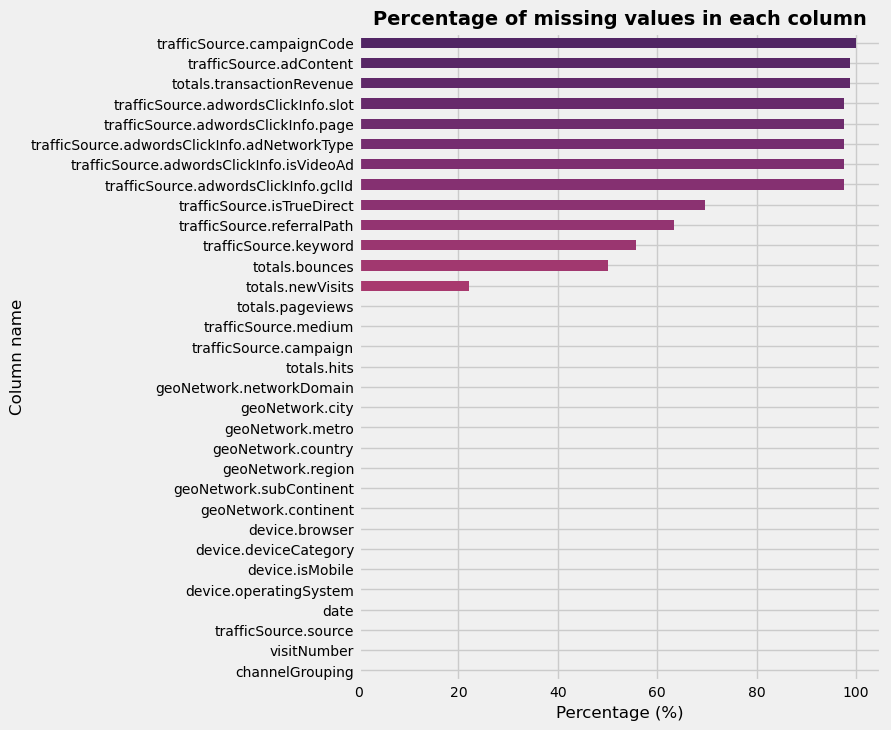

In [4]:
# Plot bar chart
ax = missing_value_df.sort_values(by='percent_missing', ascending=True)\
        .plot.barh(x='column_name', y='percent_missing',
                   figsize=(6, 8), legend=False, 
                   color=sns.color_palette("flare", missing_value_df.shape[0]),
                   )

# Set title, x/y-label, x/y-axis tick labels
ax.set_title('Percentage of missing values in each column', fontsize=14, fontweight='bold')
ax.set_xlabel('Percentage (%)', fontsize=12);
ax.set_ylabel('Column name', fontsize=12);
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show();

> 💭 <u>*Nhận xét:*</u> Trong `32` cột dữ liệu hiện có, thì:
>   * Ta thấy có `8` cột bị thiếu dữ liệu rất nghiêm trọng, tỉ lệ thiếu dữ liệu vượt quá *90%*. Trong đó có một cột chứa giá trị mục tiêu mà ta cần quan tâm.
>   * Có `5` cột cũng bị thiếu nhiều dữ liệu nhưng ít nghiêm trọng hơn, tỉ lệ chưa đến *70%*. 
>   * Các cột còn lại thường không gặp tình trạng thiếu dữ liệu, hoặc nếu có thì cũng không đáng kể.

## 🚧 Tiền xử lý các cột bị thiếu dữ liệu nghiêm trọng

#### 🎯 Với giá trị mục tiêu `totals.transactionRevenue`

Ta xem các giá trị có trong cột này

In [5]:
reduced_df['totals.transactionRevenue'].describe()

count    1.151500e+04
mean     1.337448e+08
std      4.482852e+08
min      1.000000e+04
25%      2.493000e+07
50%      4.945000e+07
75%      1.076550e+08
max      2.312950e+10
Name: totals.transactionRevenue, dtype: float64

In [6]:
reduced_df['totals.transactionRevenue'].unique()

array([       nan, 3.7860e+07, 3.0667e+08, ..., 3.3526e+08, 3.0750e+07,
       6.9390e+07])

> Cột `totals.transactionRevenue` cho biết tổng giá trị giao dịch của người dùng trong mỗi phiên truy cập. Dữ liệu của chúng ta có hơn *98%* giá trị doanh thu bị thiếu và ta có thể coi các phiên truy cập đó có doanh thu bằng *0* (không mua hàng).

🔨 Thay các giá trị `NaN` bằng `0`

In [7]:
reduced_df['totals.transactionRevenue'].fillna(0, inplace=True)

#### ✂️ Với các thuộc tính còn lại

Các thuộc tính bị thiếu quá nhiều dữ liệu (trừ giá trị mục tiêu) thường không quá hữu ích khi dùng trong phân tích. Tùy thuộc vào mục tiêu của bài toán thì ta có thể đặt ra các "giá trị ngưỡng" khác nhau. Thông thường, nếu 1 cột có hơn `75%` dữ liệu bị thiếu thì cột này được xem là thiếu dữ liệu **trầm trọng** và ta sẽ ưu tiên loại bỏ nó khỏi tập dữ liệu.

In [8]:
def drop_missing_features(df: pd.DataFrame, missing_lst: dict, threshold: float = 75.0) -> pd.DataFrame:
    """Drop missing features from Pandas dataframe base on given threshold.

    Args:
        df (pd.DataFrame): Input dataframe for processing.
        missing_lst (dict, optional): Dict missing value rate which calculated from previous stage. Defaults to dict(num_col_info_df.iloc[0]).
        threshold (float, optional): User threshold for dropping. Defaults to 75.0.

    Returns:
        pd.DataFrame: Updated dataframe
    """
    # YOUR CODE HERE
    # raise NotImplementedError()
    if (df is None) or (missing_lst is None) or (threshold is None):
        print(f"[LOG] Invalid.")
        raise ValueError
    
    # Create a copy of the dataframe to avoid changing the original
    df_cp = df.copy()
    
    # List to maintain the columns to drop
    cols_to_trim = []
    
    for key, value in missing_lst.items():
        if float(value) > threshold and key != 'totals.transactionRevenue':
            cols_to_trim.append(key)
            
    if len(cols_to_trim) > 0:
        # drop the columns identified using the dataframe drop() method
        df_cp = df_cp.drop(columns=cols_to_trim)
        print("[LOG] Dropped column(s): " + "\n + ".join([""]+cols_to_trim))
    else:
        print("[LOG] Have no column(s) to trim.")
        
    return df_cp

In [9]:
# Get new missing value dataframe after fill column 'totals.transactionRevenue'
missing_value_df = _create_missing_value_df(reduced_df)
# Drop features with high missing value rate
reduced_df = drop_missing_features(
    reduced_df,
    {col_name: percent_missing
     for col_name, percent_missing in zip(missing_value_df['column_name'],
                                          missing_value_df['percent_missing'])}
)

[LOG] Dropped column(s): 
 + trafficSource.campaignCode
 + trafficSource.adContent
 + trafficSource.adwordsClickInfo.page
 + trafficSource.adwordsClickInfo.slot
 + trafficSource.adwordsClickInfo.isVideoAd
 + trafficSource.adwordsClickInfo.adNetworkType
 + trafficSource.adwordsClickInfo.gclId


#### 🔍 Ta quan sát kết quả

In [10]:
reduced_df.sample(n=5)

,channelGrouping,date,visitNumber,device.browser,device.operatingSystem,device.isMobile,device.deviceCategory,geoNetwork.continent,geoNetwork.subContinent,geoNetwork.country,geoNetwork.region,geoNetwork.metro,geoNetwork.city,geoNetwork.networkDomain,totals.hits,totals.pageviews,totals.bounces,totals.newVisits,totals.transactionRevenue,trafficSource.campaign,trafficSource.source,trafficSource.medium,trafficSource.keyword,trafficSource.isTrueDirect,trafficSource.referralPath
459126,Social,20160922,1,Safari,Macintosh,False,desktop,Americas,South America,Brazil,not available in demo dataset,not available in demo dataset,not available in demo dataset,virtua.com.br,2,2.0,NaN,1.0,0.0,(not set),youtube.com,referral,NaN,NaN,/yt/about/pt-BR/
814691,Referral,20170602,7,Chrome,Macintosh,False,desktop,Americas,Northern America,United States,California,San Francisco-Oakland-San Jose CA,Mountain View,(not set),1,1.0,1.0,NaN,0.0,(not set),mall.googleplex.com,referral,NaN,NaN,/
531536,Organic Search,20170705,1,Chrome,Windows,False,desktop,Asia,Southeast Asia,Indonesia,Jakarta,(not set),Jakarta,unknown.unknown,2,2.0,NaN,1.0,0.0,(not set),google,organic,(not provided),NaN,NaN
386650,Social,20170131,1,Internet Explorer,Windows,False,desktop,Europe,Western Europe,Netherlands,not available in demo dataset,not available in demo dataset,not available in demo dataset,(not set),1,1.0,1.0,1.0,0.0,(not set),youtube.com,referral,NaN,NaN,/yt/about/nl/
901299,Direct,20170104,1,Chrome,Linux,False,desktop,Americas,Northern America,United States,(not set),(not set),(not set),google.com,1,1.0,1.0,1.0,0.0,(not set),(direct),(none),NaN,True,NaN


In [11]:
reduced_df.shape

(903653, 25)

> 💭 <u>*Nhận xét:*</u> Sau khi loại bỏ các cột bị thiếu dữ liệu nghiêm trọng, ta chỉ còn một bảng dữ liệu với `903653` mẫu và `25` thuộc tính. Khi này, số lượng thuộc tính đã ở mức vừa đủ (không quá nhiều cũng không quá ít) để ta có thể phân tích chi tiết trong tương lai.

## 📌 Mỗi cột hiện đang có kiểu dữ liệu gì? Có cột nào có kiểu dữ liệu chưa phù hợp để có thể xử lý tiếp không?

Đầu tiên, ta cần quan sát kiểu dữ liệu của từng cột

In [12]:
reduced_df.dtypes

channelGrouping                object
date                            int64
visitNumber                     int64
device.browser                 object
device.operatingSystem         object
device.isMobile                  bool
device.deviceCategory          object
geoNetwork.continent           object
geoNetwork.subContinent        object
geoNetwork.country             object
geoNetwork.region              object
geoNetwork.metro               object
geoNetwork.city                object
geoNetwork.networkDomain       object
totals.hits                     int64
totals.pageviews              float64
totals.bounces                float64
totals.newVisits              float64
totals.transactionRevenue     float64
trafficSource.campaign         object
trafficSource.source           object
trafficSource.medium           object
trafficSource.keyword          object
trafficSource.isTrueDirect     object
trafficSource.referralPath     object
dtype: object

> 💭 <u>*Nhận xét:*</u>
> * Cột `date` hiện có kiểu dữ liệu chưa phù hợp, ta mong đợi nó phải có kiểu `datetime` chứ không phải `int64`.
>
> * Nhóm `totals.bounces`, `totals.newVisits` và `trafficSource.isTrueDirect`:
>   * `totals.bounces` - Khi người dùng truy cập vào một website và (ngay lập tức) rời khỏi trang web đó mà không tương tác gì thêm thì giá trị `bounces` được gán bằng `1`, ngược lại thì bỏ trống.
>
>   * `totals.newVisits` - Cho biết đây có phải lần đầu tiên người dùng truy cập đến website hay không, nếu đúng thì điền giá trị `1`, còn không thì bỏ trống. 
>
>   * `trafficSource.isTrueDirect` - Nếu người dùng truy cập đến website bằng cách gõ trực tiếp URL vào browser hoặc sử dụng bookmark thì `isTrueDirect` có giá trị `True`, ngược lại thì bỏ trống.
>
>   * Như vậy, ta cần thực hiện lần lượt 2 thao tác: thay các giá trị trống bằng `False` và chuyển từng cột sang kiểu `bool`.
>
> * Các cột còn lại đều có kiểu dữ liệu đúng như ta mong đợi nên không cần phải chuyển đổi.

## 🚧 Tiền xử lý các cột có kiểu dữ liệu chưa phù hợp

##### 📅 `date` 

Ta quan sát một vài giá trị và kiểu dữ liệu của thuộc tính này

In [13]:
reduced_df["date"][100000:100005]

100000    20161030
100001    20161030
100002    20161030
100003    20161030
100004    20161030
Name: date, dtype: int64

> 💡 <u>*Quan sát*</u>: Cột `date` đang có kiểu dữ liệu là `int` và mỗi giá trị trong cột có định dạng "YYYY_MM_DD". Ta sẽ chuyển các giá trị trong cột này sang kiểu `datetime`.

🔨 Chuyển các giá trị trong cột `date` sang kiểu `datetime`

In [14]:
# Convert date to datetime type
reduced_df['date'] = pd.to_datetime(reduced_df['date'], format='%Y%m%d')

# Check the result
reduced_df['date'][100000:100005]

100000   2016-10-30
100001   2016-10-30
100002   2016-10-30
100003   2016-10-30
100004   2016-10-30
Name: date, dtype: datetime64[ns]

✨ Vì cột `date` chỉ mang giá trị tổng quát nên ta có thể trích xuất ra các thông tin hữu ích hơn từ dữ liệu này. Và các thông tin được trích xuất sẽ là các giá trị phân loại.

In [15]:
if 'date' in reduced_df.columns:
    # Extract time features from `date` column
    reduced_df['date.day']        = reduced_df['date'].dt.day
    reduced_df['date.year']       = reduced_df['date'].dt.year
    reduced_df['date.month']      = reduced_df['date'].dt.month
    reduced_df['date.weekDay']    = reduced_df['date'].dt.weekday
    reduced_df['date.weekOfYear'] = reduced_df['date'].dt.isocalendar().week

    # Change datatype of the above columns to categorical
    reduced_df['date.day']        = reduced_df['date.day'].astype('str')
    reduced_df['date.year']       = reduced_df['date.year'].astype('str')
    reduced_df['date.month']      = reduced_df['date.month'].astype('str')
    reduced_df['date.weekDay']    = reduced_df['date.weekDay'].astype('str')
    reduced_df['date.weekOfYear'] = reduced_df['date.weekOfYear'].astype('str')

    # # Sau đó, ta có thể bỏ cột `date` khỏi tập dữ liệu để tiết kiệm không gian lưu trữ.
    # # Drop `date` column
    # train_df.drop('date', axis=1, inplace=True)

##### ⌘ Nhóm `totals.bounces`, `totals.newVisits` và `trafficSource.isTrueDirect`

Ta thay giá trị trống bằng `False` rồi chuyển đổi kiểu dữ liệu của các cột thành `bool`

In [16]:
convert_to_bool_cols = ['totals.bounces', 'totals.newVisits', 
                        'trafficSource.isTrueDirect']

for col in convert_to_bool_cols:
    # Preprocess the column
    reduced_df[col] = reduced_df[col].fillna(False).astype('bool')
    
    # Check the result
    print(reduced_df[col].value_counts(dropna=False), end='\n\n')

totals.bounces
False    453023
True     450630
Name: count, dtype: int64

totals.newVisits
True     703060
False    200593
Name: count, dtype: int64

trafficSource.isTrueDirect
False    629648
True     274005
Name: count, dtype: int64



> Như vậy, ta đã chuyển đổi thành công các giá trị trống thành `False`, đồng thời chuyển đổi kiểu dữ liệu của các cột bên trên thành `bool`.

## 📌 Với mỗi cột có kiểu dữ liệu dạng số (numerical), các giá trị được phân bố như thế nào?

Ta thấy, ngoài các cột có kiểu dữ liệu `object` và `bool` được xếp vào nhóm dữ liệu phân loại (`categorical`), thì các cột còn lại đều có thể gia nhập hội `numeric`. Khi này, ta cần tìm danh sách các cột của mỗi nhóm.

In [17]:
# Non-numeric columns
non_numeric_cols = [col
                    for col in reduced_df.columns
                    if reduced_df[col].dtype in ['object', 'bool']]

# Numeric columns
numeric_cols = [col
                for col in reduced_df.columns
                if col not in non_numeric_cols]

# Check the result
print(f">> Number of numeric columns: {len(numeric_cols)}")
print(f">> Number of non-numeric columns: {len(non_numeric_cols)}")
print(f">> Number of columns appear in both lists: {len(set(non_numeric_cols).intersection(set(numeric_cols)))}")

>> Number of numeric columns: 5
>> Number of non-numeric columns: 25
>> Number of columns appear in both lists: 0


##### 📚 Với mỗi cột có kiểu dữ liệu dạng số:

* Ta sẽ tính một vài giá trị thống kê:
    - Số-lượng/tỉ-lệ các giá trị bị thiếu?
    - Giá trị min
    - Giá trị lower quartile (phân vị 25)
    - Giá trị median (phân vị 50)
    - Giá trị upper quartile (phân vị 75)
    - Giá trị max
* Sau đó quan sát và nhận xét kết quả có gì bất thường không?

In [18]:
# Get a copy of all numeric columns
num_col_info_df = reduced_df.loc[:, numeric_cols].copy()

def num_missing(s): 
    return s.isna().sum()

def missing_ratio(s): 
    return (s.isna().mean() * 100)

def median(df): 
    return (df.quantile(0.5))

def lower_quartile(df): 
    return (df.quantile(0.25))

def upper_quartile(df): 
    return (df.quantile(0.75))

num_col_info_df = num_col_info_df.agg([num_missing, missing_ratio, "min",
                                       lower_quartile, median, upper_quartile, "max"])
num_col_info_df

,date,visitNumber,totals.hits,totals.pageviews,totals.transactionRevenue
num_missing,0,0.0,0.0,100.000000,0.000000e+00
missing_ratio,0.0,0.0,0.0,0.011066,0.000000e+00
min,2016-08-01 00:00:00,1.0,1.0,1.000000,0.000000e+00
lower_quartile,2016-10-27 00:00:00,1.0,1.0,1.000000,0.000000e+00
median,2017-01-09 00:00:00,1.0,2.0,1.000000,0.000000e+00
upper_quartile,2017-04-21 00:00:00,1.0,4.0,4.000000,0.000000e+00
max,2017-08-01 00:00:00,395.0,500.0,469.000000,2.312950e+10


> 💭 <u>*Nhận xét:*</u>
> * Nhìn chung, kết quả không có gì bất thường. Hơn thế nữa, giá trị `min` và `max` của cột `date` hoàn toàn trùng khớp với thông tin đã đề cập trong `chapter 01`: dữ liệu của chúng ta được thu thập từ ngày 01/08/2016 đến 01/08/2017.
>
> * Tuy nhiên, ta nhận thấy cột `totals.pageviews` có bị thiếu một ít giá trị nên ta cần phải xử lý.

##### ⌘ Tiền xử lý cột `totals.pageviews`

🎨 Đầu tiên, ta sẽ trực quan hóa phân bố của cột này và đồng thời quan sát một số giá trị thống kê

Text(0, 0.5, 'Count')

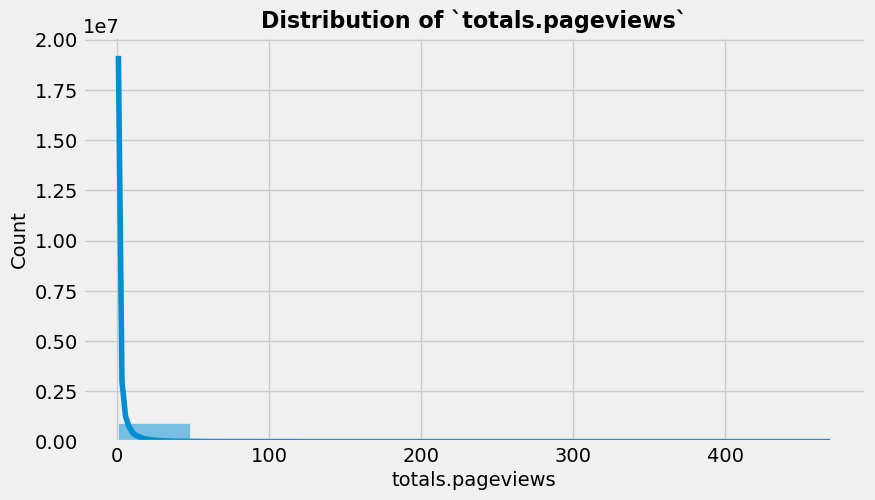

In [19]:
# Draw histogram for column `totals.pageviews`
# Reference: https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751
plt.figure(figsize=(9,5))
sns.histplot(data=reduced_df['totals.pageviews'], bins=10, kde=True)
plt.title('Distribution of `totals.pageviews`', fontsize=16, fontweight='bold')
plt.xlabel('totals.pageviews', fontsize=14)
plt.ylabel('Count', fontsize=14)

In [20]:
# View some statistics of `totals.pageviews`
reduced_df['totals.pageviews'].describe()

count    903553.000000
mean          3.849764
std           7.025274
min           1.000000
25%           1.000000
50%           1.000000
75%           4.000000
max         469.000000
Name: totals.pageviews, dtype: float64

> <u>*Nhận xét:*</u> Vì cột này bị thiếu dữ liệu nên ta có thể thay giá trị `NaN` bằng giá trị `median` của cột. Chính giá trị `NaN` đã làm cho cột này có kiểu dữ liệu `float64` nên ta có thể chuyển đổi kiểu dữ liệu của cột này thành `int` để phù hợp với ý nghĩa của thuộc tính.

❗ Thay giá trị bị thiếu bằng `median` của cột `totals.pageviews` và chuyển đổi kiểu dữ liệu của cột này thành `int`

In [21]:
# Fill `nan` with median value
reduced_df['totals.pageviews'].fillna(
    reduced_df['totals.pageviews'].median(), 
    inplace=True
)

# Change datatype of column to `int`
reduced_df['totals.pageviews'] = \
    reduced_df['totals.pageviews'].astype(np.int_)

# Display result
print("After preprocessing:")
print(f">> Number of missing values: {reduced_df['totals.pageviews'].isnull().sum()}")
print(f">> totals.pageviews's dtype: {reduced_df['totals.pageviews'].dtype}")

After preprocessing:
>> Number of missing values: 0
>> totals.pageviews's dtype: int64


## 📌 Với mỗi cột có kiểu dữ liệu dạng phân loại (categorical), các giá trị được phân bố như thế nào?

##### 📚 Với mỗi cột có kiểu dữ liệu phân loại:

* Ta sẽ:
    - Tính số-lượng/tỉ-lệ các giá trị thiếu?
    - Tính tỉ lệ các giá trị không có ý nghĩa trong việc phân tích.
    - Tính số lượng các giá trị khác nhau (không xét giá trị bị thiếu) trong mỗi cột.
    - Đưa ra (show) một vài giá trị khác nhau để minh họa và tính tỉ lệ của chúng đối với tổng số giá trị không bị thiếu của cột đó.
    <!-- - Tính tỉ lệ của từng loại giá trị trong mỗi cột đối với tổng số giá trị không bị thiếu của cột đó. -->
* Sau đó quan sát và nhận xét kết quả có gì bất thường không?

In [22]:
pd.set_option('display.max_colwidth', 100) # For clearly
pd.set_option('display.max_columns', None) # For clearly

In [23]:
# Get a copy of all non-numeric columns
cat_col_info_df = reduced_df.loc[:, non_numeric_cols].copy()

def meaningless_ratio(s):
    s = s.astype(str).str.split(';')
    s = s.explode()
    
    # Count the number of meaningless values
    meaningless_values = ['not available in demo dataset', '(not set)', 
                          '(none)', 'nan', '(not provided)',
                          'unknown.unknown']
    # meaningless_count = s.isin(meaningless_values).sum()
    num_missing = s.isna().sum()
    meaningless_count = s.isin(meaningless_values).sum()
    return (num_missing + meaningless_count) / len(s) * 100

def num_values(s):
    s = s.astype(str).str.split(';')
    s = s.explode()
    return len(s.value_counts())

def value_ratios(s):
    s = s.astype(str).str.split(';')
    s = s.explode()
    totalCount = (~s.isna()).sum()
    return ((s.value_counts()/totalCount*100).round(1)).to_dict()

cat_col_info_df = cat_col_info_df.agg([num_missing, missing_ratio, 
                                       meaningless_ratio, num_values, 
                                       value_ratios])
cat_col_info_df = cat_col_info_df.T

In [24]:
cat_col_info_df

,num_missing,missing_ratio,meaningless_ratio,num_values,value_ratios
channelGrouping,0,0.0,0.0,8,"{'Organic Search': 42.2, 'Social': 25.0, 'Direct': 15.8, 'Referral': 11.6, 'Paid Search': 2.8, '..."
device.browser,0,0.0,0.000885,54,"{'Chrome': 68.7, 'Safari': 20.2, 'Firefox': 4.1, 'Internet Explorer': 2.1, 'Edge': 1.1, 'Android..."
device.operatingSystem,0,0.0,0.519558,20,"{'Windows': 38.7, 'Macintosh': 28.1, 'Android': 13.7, 'iOS': 11.9, 'Linux': 3.9, 'Chrome OS': 2...."
device.isMobile,0,0.0,0.0,2,"{'False': 73.5, 'True': 26.5}"
device.deviceCategory,0,0.0,0.0,3,"{'desktop': 73.5, 'mobile': 23.1, 'tablet': 3.4}"
geoNetwork.continent,0,0.0,0.162452,6,"{'Americas': 49.8, 'Asia': 24.8, 'Europe': 21.9, 'Oceania': 1.7, 'Africa': 1.6, '(not set)': 0.2}"
geoNetwork.subContinent,0,0.0,0.162452,23,"{'Northern America': 43.2, 'Southeast Asia': 8.6, 'Southern Asia': 6.6, 'Western Europe': 6.5, '..."
geoNetwork.country,0,0.0,0.162452,222,"{'United States': 40.4, 'India': 5.7, 'United Kingdom': 4.1, 'Canada': 2.9, 'Vietnam': 2.7, 'Tur..."
geoNetwork.region,0,0.0,59.321,376,"{'not available in demo dataset': 56.2, 'California': 11.9, '(not set)': 3.1, 'New York': 2.9, '..."
geoNetwork.metro,0,0.0,78.569429,94,"{'not available in demo dataset': 56.2, '(not set)': 22.3, 'San Francisco-Oakland-San Jose CA': ..."


> 💭 <u>*Nhận xét:*</u> 
> * Tỉ lệ thiếu giá trị (`missing_ratio`) thấp nhưng tỉ lệ giá trị vô nghĩa (`meaningless_ratio`) cao chứng tỏ các cột này chưa đủ chất lượng để xử lý tiếp. Ta có thể xem `meaningless_ratio` thực sự là 1 loại `missing_ratio` và loại bỏ các cột có quá nhiều giá trị vô nghĩa. 
>
> * Ngoài vấn đề nêu trên thì kết quả có vẻ không có gì bất thường.

##### 🔨 Loại bỏ các cột không có nhiều ý nghĩa trong quá trình phân tích

In [25]:
reduced_df = drop_missing_features(
    reduced_df,
    {col_name: meaningless_ratio_
     for col_name, meaningless_ratio_ in zip(cat_col_info_df.index,
                                             cat_col_info_df['meaningless_ratio'])}
)

[LOG] Dropped column(s): 
 + geoNetwork.metro
 + trafficSource.campaign
 + trafficSource.keyword


Kiểm tra kết quả:

In [26]:
reduced_df.sample(n=5)

,channelGrouping,date,visitNumber,device.browser,device.operatingSystem,device.isMobile,device.deviceCategory,geoNetwork.continent,geoNetwork.subContinent,geoNetwork.country,geoNetwork.region,geoNetwork.city,geoNetwork.networkDomain,totals.hits,totals.pageviews,totals.bounces,totals.newVisits,totals.transactionRevenue,trafficSource.source,trafficSource.medium,trafficSource.isTrueDirect,trafficSource.referralPath,date.day,date.year,date.month,date.weekDay,date.weekOfYear
182557,Social,2016-08-19,1,Safari,Macintosh,False,desktop,Asia,Western Asia,United Arab Emirates,not available in demo dataset,not available in demo dataset,alshamil.net.ae,1,1,True,True,0.0,youtube.com,referral,False,/yt/about/,19,2016,8,4,33
508321,Organic Search,2017-02-23,1,Chrome,Windows,False,desktop,Europe,Western Europe,France,not available in demo dataset,not available in demo dataset,wanadoo.fr,2,2,False,True,0.0,google,organic,False,NaN,23,2017,2,3,8
236215,Direct,2017-01-29,1,Chrome,Chrome OS,False,desktop,Americas,Northern America,United States,not available in demo dataset,not available in demo dataset,rr.com,3,3,False,True,0.0,(direct),(none),True,NaN,29,2017,1,6,4
803291,Organic Search,2017-04-01,1,Chrome,Android,True,mobile,Europe,Western Europe,Netherlands,not available in demo dataset,not available in demo dataset,glasoperator.nl,1,1,True,True,0.0,google,organic,False,NaN,1,2017,4,5,13
342577,Social,2016-08-09,1,Chrome,Windows,False,desktop,Americas,South America,Brazil,State of Sao Paulo,Sao Paulo,telesp.net.br,2,2,False,True,0.0,youtube.com,referral,False,/yt/about/pt-BR/,9,2016,8,1,32


In [27]:
reduced_df.shape

(903653, 27)

> 💭 <u>*Nhận xét:*</u> 
> * Sau khi xóa các thuộc tính không cần thiết thì dữ liệu của chúng ta vẫn còn thiếu giá trị. Vì vậy, ta cần điền giá trị thích hợp vào những ô còn thiếu để có thể sử dụng trong phân tích.
> * Không giống với các dữ liệu dạng số, việc điền giá trị cho các thuộc tính phân loại thường phức tạp và tốn nhiều công sức hơn. Ta sẽ dành một phần riêng để giải quyết vấn đề này.


## 🚧 Tiền xử lý các cột có kiểu dữ liệu dạng phân loại

##### ⌘ Tiền xử lý cột `device.browser`

🎨 Đầu tiên, ta sẽ trực quan hóa phân bố của thuộc tính này bằng **bar chart**

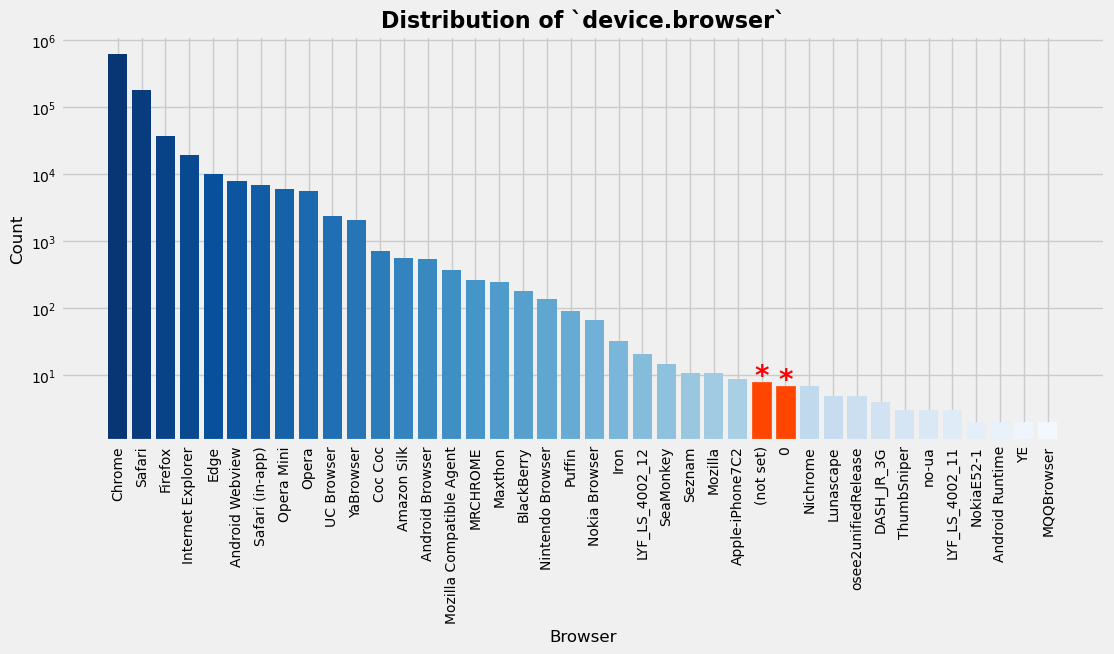

In [28]:
# Get browser value counts
browser_counts = \
    reduced_df['device.browser'].value_counts(dropna=False)[:40]

# Identify meaningless values
meaningless_idx: List[int] = []
for i, browser in enumerate(browser_counts.index):
    if browser in ["(not set)", "0"]:
        meaningless_idx.append(i)

# Visualize
plt.figure(figsize=(12,5))
ax = plt.bar(x=browser_counts.index,
             height=browser_counts.values,
             color=sns.palettes.color_palette("Blues_r", len(browser_counts.index)))
# Indicate meaningless values
for i in meaningless_idx:
    ax[i].set_color('orangered')
    # Reference: https://stackoverflow.com/questions/73189636/adding-symbols-to-some-variables-in-matplotlib-bar-plots
    plt.text(x=i, y=ax[i].get_height()*1.2, s="*", 
             ha='center', va='center', fontsize=20,
             color='red', fontweight='bold')

# Set title, labels and ticks
plt.xlabel('Browser', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.title('Distribution of `device.browser`', 
          fontsize=16, fontweight='bold')
plt.xticks(fontsize=10, rotation=90)
plt.yticks(fontsize=10)
plt.yscale('log')
plt.show()

❗ Theo như quan sát thì cột này có 2 loại giá trị đặc biệt là `(not set)` và `0`, chúng không có ý nghĩa gì cả. Đầu tiên ta sẽ xem tỉ trọng của 2 loại giá trị này.

In [29]:
# Get browser column
device_browser = reduced_df["device.browser"]

# Number of meaningless values
n_meaningless_browser_val = \
    device_browser[(device_browser == "(not set)") | (device_browser == "0")].size

# Proportion of meaningless values in the column
print(f"Proportion of meaningless values in the column: {n_meaningless_browser_val / device_browser.size * 100:.4f}%")

Proportion of meaningless values in the column: 0.0017%


🔨 Vì 2 giá trị này chiếm **tỉ trọng quá nhỏ** (bé hơn *0.1%*) nên ta có thể thực hiện xử lý cơ bản: thay 2 giá trị này thành giá trị `mode` của cột `device.browser`

In [30]:
# Mode value of the column
most_common_browser = device_browser.mode()[0]

# Replace meaningless values with the mode value
reduced_df["device.browser"].replace(
    {"(not set)": most_common_browser, "0": most_common_browser}, 
    inplace=True
)

##### ⌘ Tiền xử lý cột `device.operatingSystem`

🎨 Đầu tiên, ta sẽ trực quan hóa phân bố của thuộc tính này bằng **bar chart** 

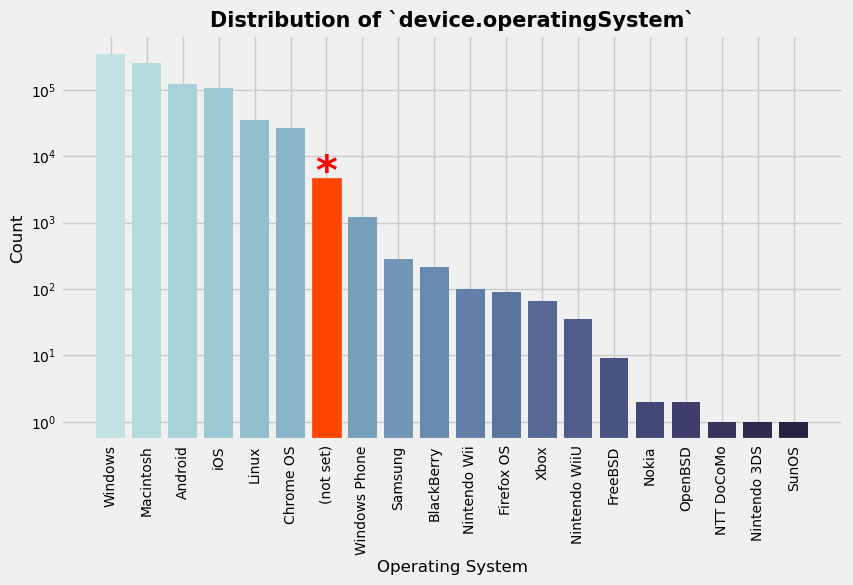

In [31]:
# Get os value counts
os_counts = \
    reduced_df["device.operatingSystem"].value_counts(dropna=False)
# Identify meaningless values
meaningless_idx: List[int] = []
for i, os in enumerate(os_counts.index):
    if os == "(not set)":
        meaningless_idx.append(i)

# Vizualize
plt.figure(figsize=(9,5))
ax = plt.bar(os_counts.index, os_counts.values,
             color=sns.color_palette("ch:start=.2,rot=-.3", len(os_counts)))
# Indicate meaningless values
for i in meaningless_idx:
    ax[i].set_color('orangered')
    plt.text(x=i, y=ax[i].get_height()*1.2, s="*", 
             ha='center', va='center', fontsize=30,
             color='red', fontweight='bold')

# Set title, labels and ticks
plt.xlabel('Operating System', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.title('Distribution of `device.operatingSystem`', 
          fontsize=15, fontweight='bold')
plt.yscale('log')
plt.xticks(fontsize=10, rotation=90)
plt.yticks(fontsize=10)
plt.show();

> 💡 <u>*Quan sát*</u>: Ta có thể kể tên một vài hệ điều hành được sử dụng phổ biến là: `Windows`, `Macintosh`, `Android`, v.v.

❗ Theo như quan sát thì cột này có 1 loại giá trị đặc biệt là `(not set)` không mang quá nhiều ý nghĩa. Đầu tiên ta sẽ xem tỉ trọng của loại giá trị này.

In [32]:
# Get OS column
device_os = reduced_df["device.operatingSystem"]

# Count the number of meaningless values
n_meaningless_os_val = device_os[device_os == "(not set)"].size

# Display the proportion of meaningless values in the column
print(f"Proportion of meaningless values in column `device.operatingSystem`: {n_meaningless_os_val / device_os.size * 100:.4f}%")

Proportion of meaningless values in column `device.operatingSystem`: 0.5196%


🔨 Vì giá trị này chiếm tỉ trọng lớn hơn *0.1%* nên ta sẽ thực hiện chuyển đổi giá trị `(not set)` $\to$ `(other)`

In [33]:
# Replace `(not set)` with `(other)`
reduced_df["device.operatingSystem"].replace(
    {"(not set)": "(other)"}, 
    inplace=True
)

##### ⌘ Tiền xử lý cột `geoNetwork.continent`

🎨 Đầu tiên, ta sẽ dùng **pie chart** để thể hiện phân bố của thuộc tính này

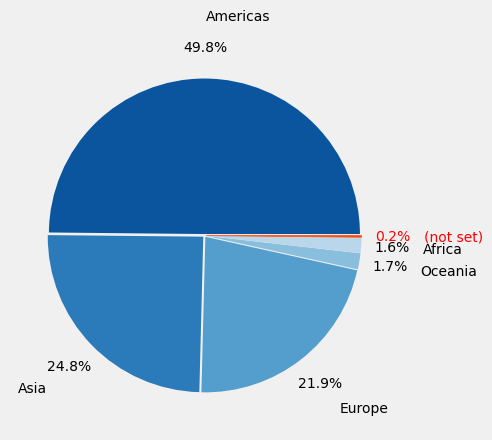

In [34]:
# Get `continent` value counts
continent_counts = \
    reduced_df["geoNetwork.continent"].value_counts(dropna=False)

# Identify meaningless values
meaningless_idx: List[int] = []
for i, continent in enumerate(continent_counts.index):
    if continent == "(not set)":
        meaningless_idx.append(i)
      
# Visualize  
patches, texts, autotexts = plt.pie(
    continent_counts, radius=1.0, labels=continent_counts.index, 
    autopct='%1.01f%%', explode=[0.01]*continent_counts.size,
    pctdistance=1.2, labeldistance=1.4, 
    colors=sns.color_palette("Blues_r", len(continent_counts))
);
# Indicate meaningless values
# Reference: https://stackoverflow.com/questions/35206282/assign-specific-colours-to-data-in-matplotlib-pie-chart
for i in meaningless_idx:
    patches[i].set_color('orangered')
    autotexts[i].set_color('red')
    texts[i].set_color('red')

# Set the font size of text in pie chart
# Reference: https://stackoverflow.com/questions/7082345/how-to-set-the-labels-size-on-a-pie-chart
for text in texts:
    text.set_fontsize(10)
for autotext in autotexts:
    autotext.set_fontsize(10)

> 📝 <u>*Nhận xét:*</u> 
> * Giá trị `Americas` chiếm khoảng *50%* tổng số giá trị (và đồng thời là yếu vị) của thuộc tính này.
> * Tuy thuộc tính này có khoảng *0.2%* giá trị trống `(not set)` nhưng con số này là bé hơn rất nhiều so với các giá trị còn lại. Đồng thời, về mặt ngữ nghĩa của cột, nếu thay `(not set)` bằng `(other)` có vẻ không ổn. Do đó, ta sẽ điền giá trị `mode` của cột này vào các ô bị trống.

🔨 Thay các giá trị `(not set)` bằng `mode` của thuộc tính này 

In [35]:
# Find mode of 'geoNetwork.continent'
geo_continent_mode = reduced_df['geoNetwork.continent'].mode()[0]

# Replace '(not set)' with mode
reduced_df['geoNetwork.continent'].replace(
    to_replace='(not set)',
    value=geo_continent_mode,
    inplace=True
)

# Check the result
reduced_df['geoNetwork.continent'].value_counts(dropna=False)

geoNetwork.continent
Americas    451845
Asia        223698
Europe      198311
Oceania      15054
Africa       14745
Name: count, dtype: int64

##### ⌘ Tiền xử lý cột `geoNetwork.subContinent`

🎨 Đầu tiên, ta sẽ vẽ **bar chart** để trực quan hóa phân bố của thuộc tính này 

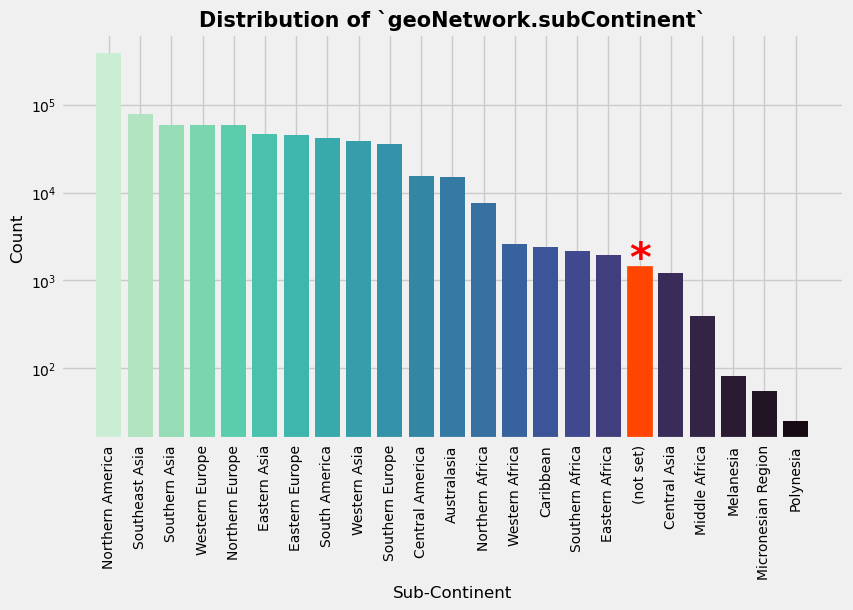

In [36]:
# Get `subContinent` value counts
subContinent_counts = \
    reduced_df["geoNetwork.subContinent"].value_counts(dropna=False)
# Identify meaningless values
meaningless_idx: List[int] = []
for i, subContinent in enumerate(subContinent_counts.index):
    if subContinent == "(not set)":
        meaningless_idx.append(i)

# Vizualize
plt.figure(figsize=(9,5))
ax = plt.bar(subContinent_counts.index, subContinent_counts.values,
             color=sns.color_palette("mako_r", len(subContinent_counts)))
# Indicate meaningless values
for i in meaningless_idx:
    ax[i].set_color('orangered')
    plt.text(x=i, y=ax[i].get_height()*1.2, s="*", 
             ha='center', va='center', fontsize=30,
             color='red', fontweight='bold')

# Set title, labels and ticks
plt.xlabel('Sub-Continent', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.title('Distribution of `geoNetwork.subContinent`', 
          fontsize=15, fontweight='bold')
plt.yscale('log')
plt.xticks(fontsize=10, rotation=90)
plt.yticks(fontsize=10)
plt.show();

> 📝 <u>*Nhận xét:*</u> Tương tự như khi xử lý với `geoNetwork.continent`, về mặt ngữ nghĩa của thuộc tính, nếu thay `(not set)` bằng `(other)` có vẻ không ổn. Do đó, ta sẽ điền giá trị `mode` của cột này vào các ô bị trống.

🔨 Thay giá trị bị trống `(not set)` bằng giá trị `mode` của cột đang xem xét

In [37]:
reduced_df["geoNetwork.subContinent"].replace(
    {"(not set)": reduced_df["geoNetwork.subContinent"].mode()[0]},
    inplace=True
)

##### ⌘ Tiền xử lý cột `geoNetwork.country`

🎨 Đầu tiên, ta sẽ vẽ **bar chart** để trực quan hóa phân bố của thuộc tính này 

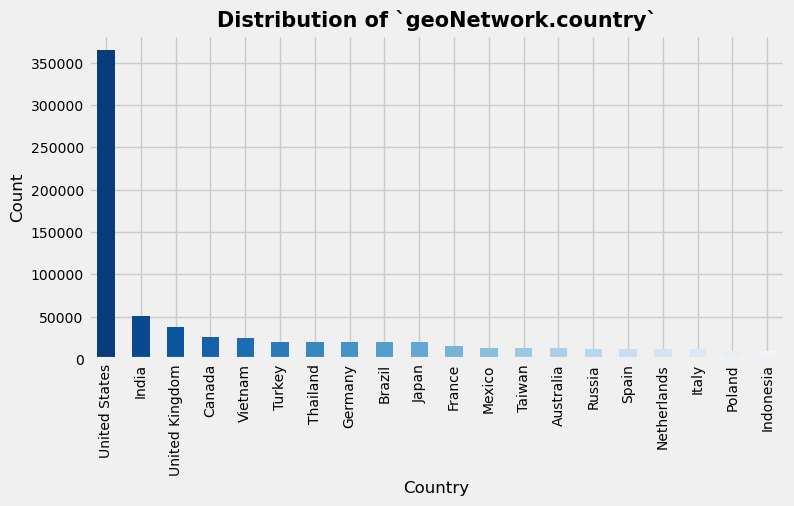

In [38]:
# Get `country` value counts
country_counts = \
    reduced_df["geoNetwork.country"].value_counts(dropna=False)[:20]

# Visualize
ax = country_counts.plot.bar(
    figsize=(8,4), 
    color=sns.color_palette("Blues_r", len(country_counts))
)
ax.set_ylabel('Count', fontsize=12);
ax.set_xlabel('Country', fontsize=12);
ax.set_title('Distribution of `geoNetwork.country`', 
             fontsize=15, fontweight='bold');
plt.xticks(fontsize=10, rotation=90)
plt.yticks(fontsize=10)
plt.show();

> 💭 <u>*Nhận xét*</u>: Số lượng phiên truy cập đến từ `US` cao hơn vượt trội so với các quốc gia khác. 

❗ Trong cột này có một vài giá trị rỗng là `(not set)`. Ta cần xem tỉ trọng của nó trên toàn bộ cột dữ liệu để quyết định bước xử lý tiếp theo.

In [39]:
# Get `country` column
country = reduced_df["geoNetwork.country"]

print(f">> Proportion of meaningless values in the column: {country[country == '(not set)'].size / country.size * 100:.2f}%")

>> Proportion of meaningless values in the column: 0.16%


🔨 Vì giá trị này chiếm tỉ trọng hơn *0.1%* nên ta sẽ thay `(not set)` $\to$ `(other)`

In [40]:
# Replace `(not set)` values with `(other)`
reduced_df["geoNetwork.country"].replace(
    {"(not set)": "(other)"},
    inplace=True
)

##### 🤔 Tiền xử lý cột `geoNetwork.region`

🎨 Đầu tiên, ta sẽ vẽ **bar chart** để thể hiện phân bố của thuộc tính này 

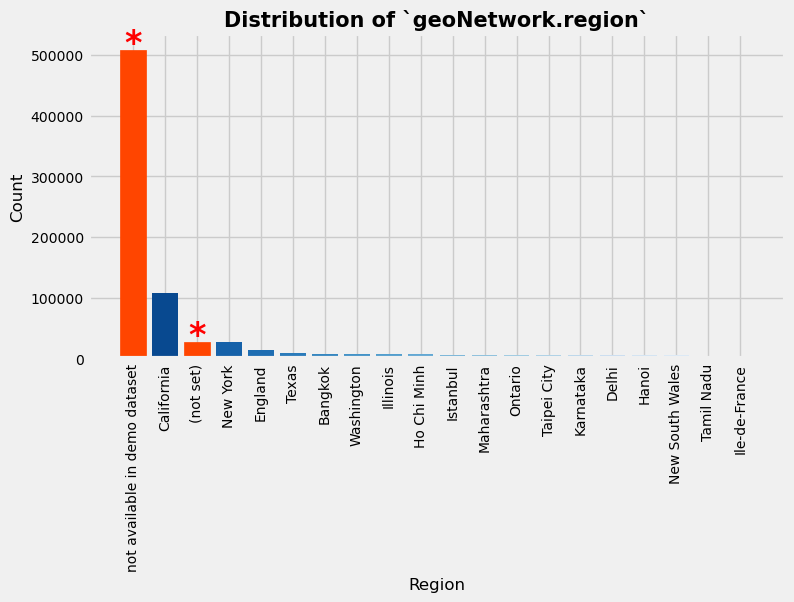

In [41]:
# Get `region` value counts
region_counts = \
    reduced_df["geoNetwork.region"].value_counts(dropna=False)[:20]
# Identify meaningless values
meaningless_idx: List[int] = []
for i, region in enumerate(region_counts.index):
    if region in ["(not set)", "not available in demo dataset"]:
        meaningless_idx.append(i)

# Visualize
plt.figure(figsize=(8,4))
ax = plt.bar(region_counts.index, region_counts.values,
             color=sns.color_palette("Blues_r", len(region_counts)))

# Indicate meaningless values
for i in meaningless_idx:
    ax.patches[i].set_color('orangered')
    plt.text(x=i, y=ax[i].get_height()+10_000, s="*", 
             ha='center', va='center', fontsize=24,
             color='red', fontweight='bold')

# Set title, labels and ticks
plt.ylabel('Count', fontsize=12);
plt.xlabel('Region', fontsize=12);
plt.title('Distribution of `geoNetwork.region`', 
          fontsize=15, fontweight='bold')
plt.xticks(fontsize=10, rotation=90)
plt.yticks(fontsize=10)
plt.show();

> 📝 <u>*Nhận xét:*</u> Hai giá trị không có nhiều ý nghĩa là `not available in demo dataset` và `(not set)` chiếm hơn *50%* tổng số giá trị của thuộc tính này. Đây là một con số khá lớn, nhưng các giá trị còn lại dường như có nhiều ý nghĩa để phân tích.

🔨 Gom các giá trị vô nghĩa thành một nhóm và đặt tên là `(other)`

In [42]:
# Replace meaningless values with `(other)`
reduced_df["geoNetwork.region"].replace(
    {"(not set)": "(other)", "not available in demo dataset": "(other)"},
    inplace=True
)

##### 🤔 Tiền xử lý cột `geoNetwork.city`

🎨 Đầu tiên, ta sẽ vẽ **bar chart** để thể hiện phân bố của thuộc tính này 

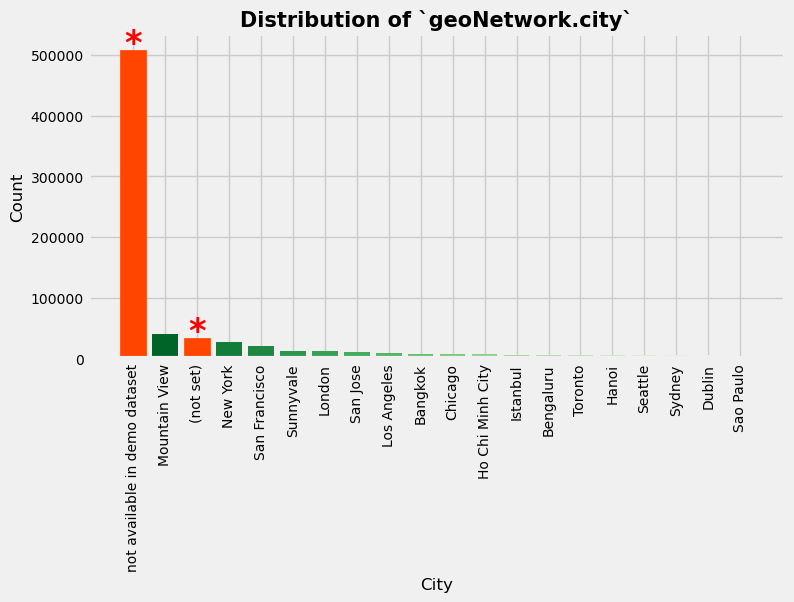

In [43]:
# Get `city` value counts
city_counts = \
    reduced_df["geoNetwork.city"].value_counts(dropna=False)[:20]
# Identify meaningless values
meaningless_idx: List[int] = []
for i, city in enumerate(city_counts.index):
    if city in ["(not set)", "not available in demo dataset"]:
        meaningless_idx.append(i)

# Visualize
plt.figure(figsize=(8,4))
ax = plt.bar(city_counts.index, city_counts.values,
             color=sns.color_palette("Greens_r", len(city_counts)))

# Indicate meaningless values
for i in meaningless_idx:
    ax.patches[i].set_color('orangered')
    plt.text(x=i, y=ax[i].get_height()+10_000, s="*", fontsize=24,
             ha='center', va='center', color='red', fontweight='bold')

plt.ylabel('Count', fontsize=12);
plt.xlabel('City', fontsize=12);
plt.title('Distribution of `geoNetwork.city`', 
          fontsize=15, fontweight='bold')
plt.xticks(fontsize=10, rotation=90)
plt.yticks(fontsize=10)
plt.show();

> 📝 <u>*Nhận xét:*</u> Cột này có nhiều nét tương đồng với thuộc tính `geoNetwork.region`. Do đó, ta sẽ áp dụng lại cách tiền xử lý trước đó.

🔨 Gom các giá trị vô nghĩa thành một nhóm và đặt tên là `(other)`

In [44]:
# Replace meaningless values with `(other)`
reduced_df["geoNetwork.city"].replace(
    {"(not set)": "(other)", "not available in demo dataset": "(other)"},
    inplace=True
)

##### ✂️ Tiền xử lý cột `geoNetwork.networkDomain`

>   Theo [thông tin tìm kiếm được](https://support.google.com/analytics/answer/3437719?hl=en-GBanswer=1686200#:~:text=geoNetwork.networkDomain) thì `geoNetwork.networkDomain` là tên miền của `ISP` (nhà cung cấp dịch vụ mạng) cho người dùng, xuất phát từ tên miền được đăng ký theo địa chỉ IP của `ISP`. Thuộc tính này không chứa nhiều thông tin hữu ích cho việc phân tích dữ liệu nên nó không còn được hỗ trợ bởi các phiên bản `Google Analytics` sau này. 
>
> **⇨** Từ thông tin thu thập được, ta quyết định loại bỏ cột `geoNetwork.networkDomain` ra khỏi tập dữ liệu.

🔨 Loại bỏ thuộc tính này khỏi tập dữ liệu

In [45]:
# Drop column `geoNetwork.networkDomain` from the dataframe
if "geoNetwork.networkDomain" in reduced_df.columns:
    reduced_df.drop("geoNetwork.networkDomain", axis=1, inplace=True)

##### 🔴 Tiền xử lý cột `trafficSource.source`

Đầu tiên, ta có thể dùng **Word Cloud** để tìm ra các `source` phổ biến

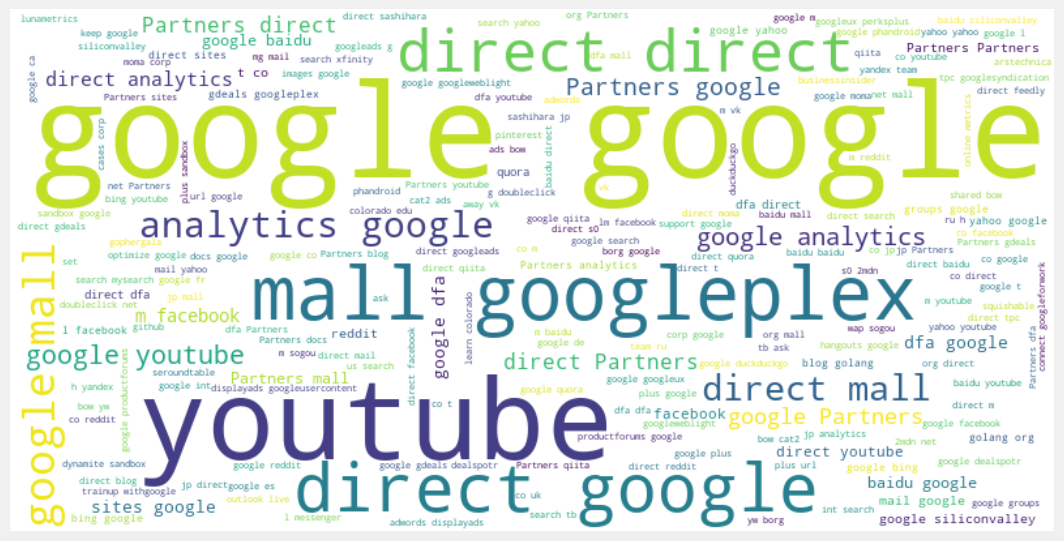

In [46]:
# Get original data from column `trafficSource.source`
source = reduced_df['trafficSource.source'].fillna('').str.strip()

# Reference: https://www.datacamp.com/tutorial/wordcloud-python
# Create and generate a word cloud image:
wordcloud = WordCloud(
    width=800, height=400, background_color="white",
    max_font_size=100,
).generate(' '.join(source))

# Display the generated image:
plt.figure(figsize=(12,9))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

🔨 Vì cột này có rất nhiều dữ liệu tương đồng nên ta sẽ gom cụm chúng thông qua kết quả của mô hình `KMeans` (phần code cụ thể nằm ở cuối file này).

In [47]:
def _clustering_traffic_source(x):
    if   'direct'           in x: return 'direct'
    elif 'googleplex'       in x: return 'googleplex'
    elif 'partners'         in x: return 'partners'
    elif 'siliconvalley'    in x: return 'siliconvalley'
    elif 'dfa'              in x: return 'DoubleClick for Advertisers'
    elif 'bing'             in x: return 'bing'
    elif 'yahoo'            in x: return 'yahoo'
    elif 'search'           in x: return 'other search engines'
    elif 'ask'              in x: return 'other search engines'
    elif 'pinterest'        in x: return 'pinterest'
    elif 'youtube'          in x: return 'youtube'
    elif 'images.google'    in x: return 'google images'
    elif 'baidu'            in x: return 'baidu'
    elif 'github'           in x: return 'github'
    elif 'facebook'         in x: return 'facebook'
    elif 'twitter'          in x: return 'twitter'
    elif 't.co'             in x: return 'twitter'
    elif 'telegram'         in x: return 'telegram'
    elif 'whatsapp'         in x: return 'whatsapp'
    elif 'reddit'           in x: return 'reddit'
    elif 'qiita'            in x: return 'qiita'
    elif 'quora'            in x: return 'quora'
    elif 'linkedin'         in x: return 'linkedin'
    elif 'amazon'           in x: return 'amazon'
    elif 'messenger'        in x: return 'messenger'
    elif 'yandex'           in x: return 'yandex'
    elif 'direct'           in x: return 'direct'
    elif 'adwords'          in x: return 'adwords'
    elif 'adz'              in x: return 'adwords'
    elif 'ads'              in x: return 'adwords'
    elif 'businessinsider'  in x: return 'businessinsider'
    elif 'google'           in x: return 'google'
    else: return 'others'

In [48]:
# Get trafficSource.source column
traffic_source = reduced_df['trafficSource.source'].copy()

# Standardize trafficSource.source column
traffic_source = traffic_source.apply(lambda x: x.lower())
traffic_source = traffic_source.apply(lambda x: re.sub(r":[\d]*$", '', x))
traffic_source = traffic_source.apply(lambda x: re.sub(r"\.com[\w\.]*$", '', x))
traffic_source = traffic_source.apply(_clustering_traffic_source)

# Reassign trafficSource.source column
reduced_df['trafficSource.source'] = traffic_source

🎨 Ta dùng **bar chart** để thể hiện phân bố của thuộc tính `trafficSource.source` sau khi biến đổi 

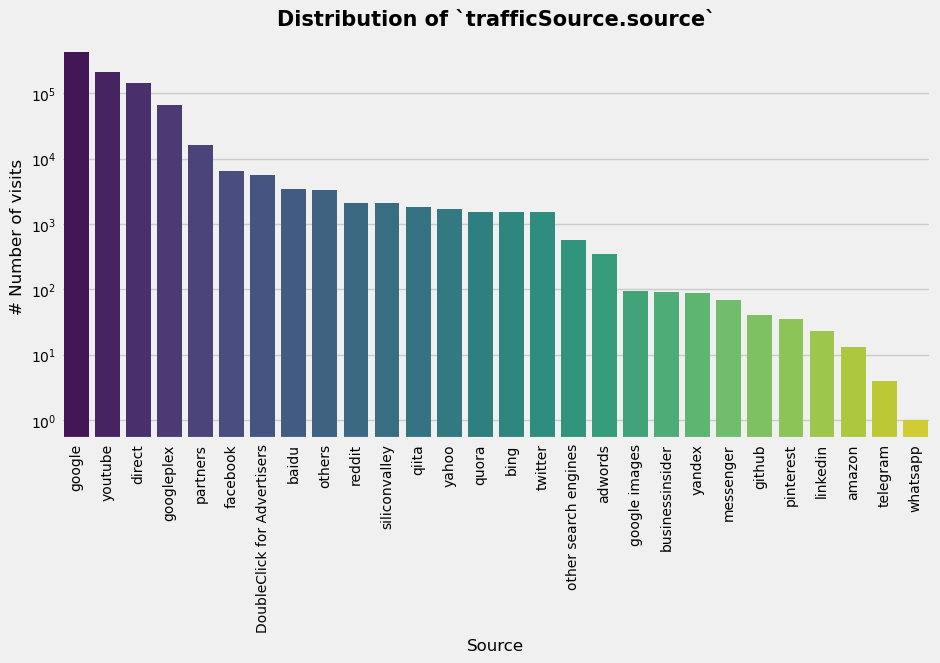

In [49]:
# Get number of each `trafficSource.source` in the column
traffic_source_val_counts = reduced_df["trafficSource.source"].value_counts(dropna=False)
# traffic_source_val_counts = traffic_source.value_counts(dropna=False)

# Viz.
plt.figure(figsize=(10,5))
ax = sns.barplot(x=traffic_source_val_counts.index,
                 y=traffic_source_val_counts.values,
                 hue=traffic_source_val_counts.index,
                 palette="viridis", orient='x',)

# Set x-axis, y-axis and title
plt.yscale('log')
ax.set_xlabel("Source", fontsize=12)
ax.set_ylabel("# Number of visits", fontsize=12)
ax.set_title("Distribution of `trafficSource.source`", fontsize=15, fontweight='bold')
plt.xticks(fontsize=10, rotation=90)
plt.yticks(fontsize=10)
plt.show();

##### 🔴 Tiền xử lý cột `trafficSource.medium`

🎨 Đầu tiên, ta sẽ vẽ **bar chart** để thể hiện phân bố của thuộc tính này 

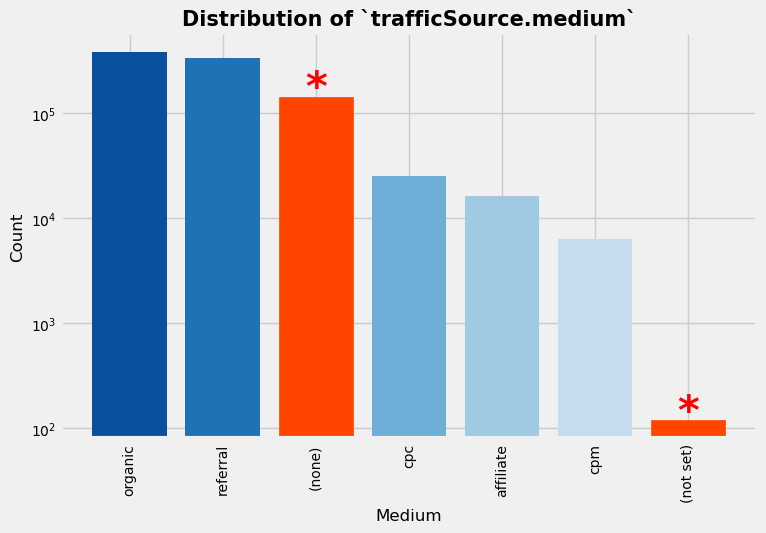

In [50]:

# Get `medium` value counts
medium_counts = reduced_df["trafficSource.medium"].value_counts(dropna=False)
# Identify meaningless values
meaningless_idx: List[int] = []
for i, medium in enumerate(medium_counts.index):
    if medium in ["(none)", "(not set)"]:
        meaningless_idx.append(i)

# Viz.
plt.figure(figsize=(8,5))
ax = plt.bar(medium_counts.index, medium_counts.values,
             color=sns.color_palette("Blues_r", len(medium_counts)))
# Indicate meaningless values
for i in meaningless_idx:
    ax[i].set_color('orangered')
    plt.text(x=i, y=ax[i].get_height()*1.2, s="*", fontsize=30,
             ha='center', va='center', color='red', fontweight='bold')

# Set title, labels and ticks
plt.xlabel('Medium', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.title('Distribution of `trafficSource.medium`', 
          fontsize=15, fontweight='bold')
plt.yscale('log')
plt.xticks(fontsize=10,rotation=90)
plt.yticks(fontsize=10)
plt.show();

> 💡 <u>Quan sát</u>:
> * Ban đầu ta sẽ nghĩ `(none)` và `(not set)` là giống nhau, nhưng theo bài viết [Direct/None Traffic in Google Analytics 4](https://www.optizent.com/blog/direct-none-traffic-in-google-analytics-4-understanding-the-different-types/): 
>   * "None/Direct web traffic" là thuật ngữ chỉ lượng truy cập của người dùng vào một trang web mà không qua bất kỳ website trung gian (referral source) nào. "Direct traffic" gồm 2 hình thức phổ biến nhất là: nhập URL vào thanh tìm kiếm và dùng bookmarks, và một vài hình thức khác.
>   * Theo một [bài viết khác](https://social.colostate.edu/best-practices/understanding-traffic-source-and-medium-in-google-analytics/#:~:text=If%20Google%20Analytics%20is%20unable%20to%20bucket%20your%20traffic%20into%20any%20of%20the%20above%2Dmentioned%20media%2C%20it%20will%20be%20categorized%20as%20Direct%20traffic.%20SEO%20research%20over%20the%20years%20has%20indicated%20that%20up%20to%2060%25%20of%20the%20traffic%20reported%20as%20Direct%20could%20actually%20be%20organic%20traffic.), có tới 60% lưu lượng truy cập được phân loại "Direct" thì thực sự là "organic". Nhưng trong đồ án này ta chỉ (đơn giản) xem chúng là 2 nhóm khác nhau. 
>
> * Như vậy, ta sẽ đổi giá trị `(none)` trong cột này sang một cái tên có ý nghĩa hơn là `direct` và đổi giá trị `(not set)` thành `(other)`.

🔨 Chuyển giá trị `(none)` $\to$ `direct` và `(not set)` $\to$ `(other)`

In [51]:
# Change some `trafficSource.medium` column's values
reduced_df["trafficSource.medium"].replace({
    "(none)": "direct",
    "(not set)": "(other)"
}, inplace=True)

##### 🤔 Tiền xử lý cột `trafficSource.referralPath`

Ta quan sát một vài giá trị trong cột này

In [52]:
reduced_df['trafficSource.referralPath'].value_counts(dropna=False)

trafficSource.referralPath
NaN                                                                                                                                                                                                                 572712
/                                                                                                                                                                                                                    75523
/yt/about/                                                                                                                                                                                                           71036
/analytics/web/                                                                                                                                                                                                      14620
/yt/about/tr/                                                                                    

> * Thuộc tính này có hơn `60%` dữ liệu bị thiếu và các giá trị có trong cột cũng tương đối và khó phân tích nên ta có thể bỏ cột này khỏi tập dữ liệu.
>> * [Referral Path](https://neilpatel.com/blog/referral-paths-in-google-analytics/) đề cập đến đường dẫn hoặc chuỗi các trang web mà người dùng đã truy cập để đến trang web hiện tại.
>> * Trong Google Analytics, `Referral Path` cho phép chúng ta xem các trang web khác đã giới thiệu người dùng đến trang web của mình.

🔨 Loại bỏ cột `trafficSource.referralPath` khỏi tập dữ liệu

In [53]:
if 'trafficSource.referralPath' in reduced_df.columns:
    reduced_df.drop('trafficSource.referralPath', axis=1, inplace=True)

---

## 💾 Lưu lại dữ liệu sau khi hoàn tất tiền xử lý

In [54]:
print(f">> Total number of features: {reduced_df.shape[1]}")
reduced_df.dtypes

>> Total number of features: 25


channelGrouping                       object
date                          datetime64[ns]
visitNumber                            int64
device.browser                        object
device.operatingSystem                object
device.isMobile                         bool
device.deviceCategory                 object
geoNetwork.continent                  object
geoNetwork.subContinent               object
geoNetwork.country                    object
geoNetwork.region                     object
geoNetwork.city                       object
totals.hits                            int64
totals.pageviews                       int64
totals.bounces                          bool
totals.newVisits                        bool
totals.transactionRevenue            float64
trafficSource.source                  object
trafficSource.medium                  object
trafficSource.isTrueDirect              bool
date.day                              object
date.year                             object
date.month

In [55]:
# Save the preprocessed dataframe
reduced_df.to_csv('../data/processed/train_preprocessed.csv', index=False)

In [56]:
# Test the result
preprocessed_df = pd.read_csv('../data/processed/train_preprocessed.csv')
preprocessed_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 903653 entries, 0 to 903652
Data columns (total 25 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   channelGrouping             903653 non-null  object 
 1   date                        903653 non-null  object 
 2   visitNumber                 903653 non-null  int64  
 3   device.browser              903653 non-null  object 
 4   device.operatingSystem      903653 non-null  object 
 5   device.isMobile             903653 non-null  bool   
 6   device.deviceCategory       903653 non-null  object 
 7   geoNetwork.continent        903653 non-null  object 
 8   geoNetwork.subContinent     903653 non-null  object 
 9   geoNetwork.country          903653 non-null  object 
 10  geoNetwork.region           903653 non-null  object 
 11  geoNetwork.city             903653 non-null  object 
 12  totals.hits                 903653 non-null  int64  
 13  totals.pagevie

___

# <center>**CHAPTER BREAK**</center>

---

___

# <center>**IMPLEMENT CLUSTERING MODEL**</center>
___

In [57]:
# from sklearn.feature_extraction.text import TfidfVectorizer
# from sklearn.cluster import KMeans
# import numpy as np

# # Your list of text values
# text_values = [
#     # ... (paste your list here)
# ]
# text_values = s.value_counts().index
# # Convert text to numerical data using TF-IDF
# vectorizer = TfidfVectorizer(stop_words='english')
# X = vectorizer.fit_transform(text_values)

# # Choose the number of clusters (you may need to adjust this based on your data)
# num_clusters = 15

# # Apply K-Means clustering
# kmeans = KMeans(n_clusters=num_clusters, random_state=42)
# kmeans.fit(X)

# # Get cluster labels
# cluster_labels = kmeans.labels_

# # Print the clusters
# for i in range(num_clusters):
#     print(f"Cluster {i + 1}:")
#     cluster_texts = np.array(text_values)[cluster_labels == i]
#     for text in cluster_texts:
#         print(f"  - {text}")
#     print("\n")

In [58]:
# def _clustering_keyword(x):
#     if 'tube'       in x: return "youtube"
#     if 'tub'        in x: return "youtube"
#     if 'you'        in x: return "youtube"
#     if 'yot'        in x: return "youtube"
#     if 'yu'         in x: return "youtube"
#     if 'yt'         in x: return "youtube"
#     if 'ypu'        in x: return "youtube"
#     if 'ube'        in x: return "youtube"
#     if 'tbe'        in x: return "youtube"
#     if 'tobe'       in x: return "youtube"
#     if 'yoo'        in x: return "youtube"
#     if 'υουτυβε'    in x: return "youtube"
#     if 'yoiu'       in x: return "youtube"
#     if 'tuibe'      in x: return "youtube"
#     if 'tbue'       in x: return "youtube"
    
#     if 'buy'    in x and 'google'   in x: return "buy + google"
#     if 'shirt'  in x and 'google'   in x: return "google + (t-)shirt"
#     if 'shirt'  in x and 'goog'     in x: return "google + (t-)shirt"
#     if 'lava'   in x and 'lamp'     in x: return "lava + lamp"
    
    
#     if ("goog" in x or "goof" in x or "geogle" in x or "geogle" in x or "oolge" in x) \
#         and ('mer' in x or 'mar' in x or 'chandise' in x or 'sto' in x or 'ore' in x \
#                 or 'stroe' in x or 'shop' in x):
#         return "google + merchandise/store/shop"
    
#     if 'bottle' in x or 'boottle' in x or 'botl' in x: 
#         return "(water) bottle"
#     if 'bag' in x and 'google' not in x: 
#         return "bag"
    
#     if 'google' in x or 'goog' in x or 'oogle' in x: 
#         return "google (brand)"
    
#     if ("android" in x) and ('mer' in x or 'mar' in x or 'chandise' in x \
#         or 'sto' in x or 'ore' in x  or 'stroe' in x or 'shop' in x):
#         return "android + merchandise/store/shop"
#     if "android" in x or "andriod" in x: 
#         return "android (brand)"
    
#     if ('chandise' in x or 'mer' in x or 'mar' in x or 'shop' in x or 'store' in x):
#         return "other merchandise/store/shop"
    
#     if "sunglasses" in x: return "sunglasses"
#     if "shirt" in x or "shart" in x or "shert" in x or "shi" in x or "shrit" in x \
#         or "shrt" in x or "shet" in x or "sirt" in x: 
#         return "(t-)shirt"
    
#     if "pen"        in x: return "pen"
#     if "nest"       in x: return "pen"
#     if "mug"        in x: return "mug"
#     if "stickers"   in x: return "stickers"
#     if "bluetooth"  in x: return "bluetooth"
#     if "tumblers"   in x: return "tumblers"
#     if "apparel"    in x: return "apparel"
#     if "backpack"   in x: return "backpack"
#     if "hoodie"     in x: return "hoodie"
    
#     if "journal" in x or "notebook" in x: 
#         return "notebooks + journals"
    
#     return "others"

In [59]:
# s = train_df['trafficSource.keyword'].copy()
# s = s.apply(lambda x: str(x).replace('+', ''))
# s = s.apply(lambda x: str(x).lower())
# s = s.apply(lambda x: re.sub(r"goo[oh]gle?", 'google', x))
# s = s.apply(lambda x: re.sub(r"gog[g]?le", 'google', x))
# s = s.apply(lambda x: re.sub(r"goole", 'google', x))
# s = s.apply(lambda x: re.sub(r"goo[l]?gel", 'google', x))
# s = s.apply(lambda x: re.sub(r"gog[oa]le", 'google', x))
# s = s.apply(lambda x: re.sub(r"\.?g[ou]gel\.?", 'google', x))
# s = s.apply(lambda x: re.sub(r"gtoogle", 'google', x))
# s = s.apply(lambda x: re.sub(r"g(ò|po|\.\.|oi|aa|ol|ood|ou|ool|opp)g(le|al)", 'google', x))
# s = s.apply(lambda x: re.sub(r"\woo[gh]le", 'google', x))
# s = s.apply(_my_func)
# s.value_counts(dropna=False).shape